In [2]:
import numpy as np
import pandas as pd
import glob

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy.sparse import random
import librosa
import matplotlib.pyplot as plt
from scipy.spatial import distance
from numpy.random import default_rng
import soundfile as sf
import os
from numpy.linalg import norm

## Create data

### Create white noise data

In [4]:
def make_noises(mu=0, sigma=1, n=10, t_size=10000):
    rng = np.random.default_rng()
    noises = rng.normal(mu, sigma, (n,t_size))
#     for i in range(n):
# #         mu = float(rng.normal(0, 1, 1))
# #         sigma = abs(float(rng.normal(0, 2, 1)))
#         noise = rng.normal(mu, sigma, t_size)
#         if noises.size > 0:
#             noises = np.vstack((noises,noise))
#         else:
#             noises = noise.copy()
    return(noises)

### Create MFCCs
#### Currently not using

In [5]:
def make_mfcc(folder):
    """
    Go through the folder and find all (and only) files ending with .wav
    Here, we transform each .wav file into MFCCs and then flatten them into one vector.
    We do this because we want one hash per .wav file.
    
    Any file shorter than the longest file in the folder will be padded with values 0,
    so that all concatenated file vectors are of the same length.
    
    Parameters
    ----------
    folder : path to folder with wav sounds
    
    Returns
    -------
    a list of flattened MFCC vectors
    """
    vectors = []
    for file in [x for x in os.listdir(folder) if x.endswith(".wav")]:
        filename = os.path.join(folder, file)
        y, sr = librosa.load(filename)
        mfcc_feat = librosa.feature.mfcc(y=y, sr=sr)
        vect = mfcc_feat.flatten()
        vectors.append(vect)
        print(len(vectors), " mfccs done")
    # find the largest vector
    max_length = len(max(vectors, key=lambda p: len(p)))
    # append zeros to all the other vectors
    for i in range(len(vectors)):
        vectors[i] = np.pad(vectors[i], (0,max_length-len(vectors[i])))
    return vectors

## Create hashed data

### Fly olfactory algorithm hashing from [1]

In [6]:
# def make_binary_lsh(X, m, seed=82):
#     """
#     Hash the data with binary locality sensitive-hashing algorithm from Supplementary materials of [1].
    
#     h : R^d --> Z^m, d<<m
#     y = sgn(Mx)
    
#     M : dense i.i.d. Gaussian random matrix
#     x : input
    
#     Parameters
#     ----------
#     X : np array
#         input vectors
#     m : int
#         dimension of the output
    
#     Returns
#     -------
#     h : np array
#         hashed output y of dimension m
#     """
    
#     d = X.shape[1]
#     rng = default_rng(seed)
#     M = rng.standard_normal((m,d))
#     h = []
#     y = np.inner(M,X)
#     y = np.sign(y)
#     y[y<=0] = 0
#     h = np.transpose(y)
# #     for x in X:
# #         y = np.inner(M,x)
# #         y = np.sign(y)
# #         y[y<=0] = 0
# #         h.append(np.transpose(y))
    
# #     return(np.array(h))
#     return(h)

In [7]:
def apply_hash(X, M, k):
    """
    Define the hashing of the data with binary fly WTA hashing algorithm [1] - Supplementary material.
    
    h : R^d --> Z^m, d<<m
    
    M is a sparse m x d matrix, 1 if input connects to output, 0 otherwise.
    y = Mx, where values are 1 if y_i is one of the k largest values in y, 0 otherwise.
    
    Parameters
    ----------
    X : np array
        input vectors
    M : np array
        hash matrix
    k : int
        number of active values in an array, k=N*p

    Returns
    -------
    h : np array
        hashed output y of dimension m
    """
    assert X.shape[1] == M.shape[1]
    
    y = np.inner(M,X)
    h = np.transpose(y)
    top_z = np.argsort(h) # sort by size, get from smallest to largest indices
    top_k = top_z[:,-k:] # top k elements
    bottom_k = top_z[:,:-k]
    for i in range(h.shape[0]):
        h[i][top_k[i]] = 1
        h[i][bottom_k[i]] = 0
        
    return(h)
    
def generate_hash_matrix(d, m, seed = 30):
    """
    Define the hashing matrix of the binary fly WTA hashing algorithm [1] - Supplementary material.
    
    M is a sparse m x d matrix, 1 if input connects to output, 0 otherwise.
    y = Mx, where values are 1 if y_i is one of the k largest values in y, 0 otherwise.
    
    Parameters
    ----------
    d : int
        input vector's dimension
    m : int
        dimension of the hashed output
    seed : int
        randomizing seed

    Returns
    -------
    M : np array
        hash matrix, m x d
    """
    rng = default_rng(seed)
    p = 6/d
    M = np.zeros((m,d))
    M[rng.random(M.shape) < p] = 1
    
    return(M)


p = 0.1
d = 10000
N = 100
k = int(N*p)
X = make_noises(n=10, t_size=d)
M = generate_hash_matrix(d, N)
h = apply_hash(X, M, k)

### WTA hash from [2]

In [8]:
def hash_dim(d,k,m,seed):  
    
    """
    Define hash parameters.
    The hash will be a matrix of the dimension = k*m
    We choose a random number k of units of the vector.
    
    Parameters
    ----------
    d : num
        Length of a random vector being stored
    k : num
        Number of units we randomly choose of the vector
    m : num
        Number of times we will  do the hashing for some vector
    seed : num
        We always want the same units randomly chosen
        
    Returns
    -------
    a numpy array 
        p of dimensions [k,m] represents randomly chosen dimensions
    
    """   
    assert k <= d
    p = np.zeros((m,k,))
    np.random.seed(seed)
    for i in range(m):
        p[i] = np.random.permutation(d)[:k]
    return p

    
def get_hash(vector, k, m, p): 
    """
    Transform a vector of speech into a hash
    The hash will be a matrix of the dimension = k*m
    
    Once we have chosen k random dimensions, we look for the highest 
    value and turn it into 1. Everything else is 0.
    We thus get sparse matrices.
    We do this m times. Final output is h=k*m.
    
    Parameters
    ----------
    vector : np.array
        Features (i.e. MFCC) of some sound with dim = 1*n
    k : num
        Number of units we randomly choose of the vector
    m : num
        Number of times we will do the hashing for some vector.
    p : numpy array
        p of dimensions [k,m] represents randomly chosen dimensions
        
    Returns
    -------
    a numpy array h of size [1, k*m]
    """
    h = np.zeros((m,k,))
    for i in range(m):
        p_line = p[i].astype(int)
        ix = np.argmax(vector[p_line])
        hi = np.zeros(k)
        hi[ix] = 1
        h[i] = hi
    h = np.hstack(h)
    return h

def hash_dataset(mfccs_vectors, k, m, SEED):
    """
    Make a hashed dataset with parameters k and m and with the extracted mfccs.

    Parameters
    ----------
    mfccs_vectors : numpy array
        array of mfcc vector arrays extracted from an audio file, each array is a file
    k : num
        Number of units we randomly choose of the vector
    m : num
        Number of times we will do the hashing for some vector.
    Returns
    -------
    list
        We return a list of numpy arrays, each representing a hashed audio file
    """
    d = len(mfccs_vectors[0])
    V =[]
    p = hash_dim(d,k,m,SEED).astype(int)
    for vect in mfccs_vectors:
        v = get_hash(vect, k, m, p)
        V.append(v) 
    return V

def make_hash_dataset(noise_mfcc, p, N, SEED = 5):

    k = int(1/p)
    assert k == 1/p
    m = int(N/k)
    assert m == N/k, (m,N/k)
    print("k, m: ", k, m)       
    V = hash_dataset(noise_mfcc, k, m, SEED)
    return(V)

## Distances

In [9]:
def hamming_dist(x ,y):
    dist = np.count_nonzero(x!=y)
    return(dist)

In [10]:
def euclid_dist(x, y):
    dist = norm(x-y)
    return(dist)

In [11]:
def euclid_dist_threshold(x, y, threshold):
    dist = min(norm(x-y),threshold)
    return(dist)

In [12]:
def do_S2(x,y):
    assert x.shape == y.shape
    R_XY = []
    for i in range(x.shape[0]):
        LXi = np.where(x < x[i])[0]
        LYi = np.where(y < y[i])[0]
        R_XY.append(np.intersect1d(LXi,LYi).shape[0])
    dist = np.sum(R_XY)
    return(dist)

## Analyze capacity

In [13]:
# for i,noise in enumerate(noise_vects):
#     sf.write('./noises/noise_'+str(i)+'.wav', noise, 16000)
    
# n_path = os.path.abspath('./noises')
# noise_mfcc = make_mfcc(n_path)
# # store the mfccs as a pickle file 
# # with open("noise_mfcc.txt", "wb") as fp:
# #      pickle.dump(mfccs_vectors, fp)

In [14]:
N_list = [100, 200, 500]
P_list = [0.05, 0.1, 0.2]
n = 10000

res = {'N':[], 'p':[], 'hashed_dist':[], 'eucl_dist':[], 'S2_dist':[]}

d = 10
X = make_noises(n=n, t_size=d)
Y = make_noises(n=n, t_size=d)

print("made noises")

euclid_dist = []
S2_dist = []
for i in range(X.shape[0]):
    if i % 100 == 0:
        print(i)
    euclid_dist.append(norm(X[i] - Y[i]))
    S2_dist.append(do_S2(X[i], Y[i]))

for N in N_list:
    M = generate_hash_matrix(d, N)
    for p in P_list:
        print(N,p)
        k = int(N*p)
        h_x = apply_hash(X, M, k)
        h_y = apply_hash(Y, M, k)
            
        for i in range(X.shape[0]):
            ham_dist = hamming_dist(h_x[i],h_y[i])
            res['S2_dist'].append(S2_dist[i])
            res['hashed_dist'].append(ham_dist)
            res['eucl_dist'].append(euclid_dist[i])
#             res['i'].append(i)
#             res['j'].append(j)
            res['N'].append(N)
            res['p'].append(p)

res = pd.DataFrame(res)

made noises
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
100 0.05
100 0.1
100 0.2
200 0.05
200 0.1
200 0.2
500 0.05
500 0.1
500 0.2


In [15]:
res

N     p  hashed_dist  eucl_dist  S2_dist
0      100  0.05            8   4.164602       22
1      100  0.05           10   5.752990        9
2      100  0.05           10   4.520135       18
3      100  0.05           10   5.782758       11
4      100  0.05            8   4.274023       26
...    ...   ...          ...        ...      ...
89995  500  0.20          104   3.176249       39
89996  500  0.20          176   3.972823       19
89997  500  0.20          190   4.728236       13
89998  500  0.20          188   3.919838       16
89999  500  0.20          110   3.543503       30

[90000 rows x 5 columns]

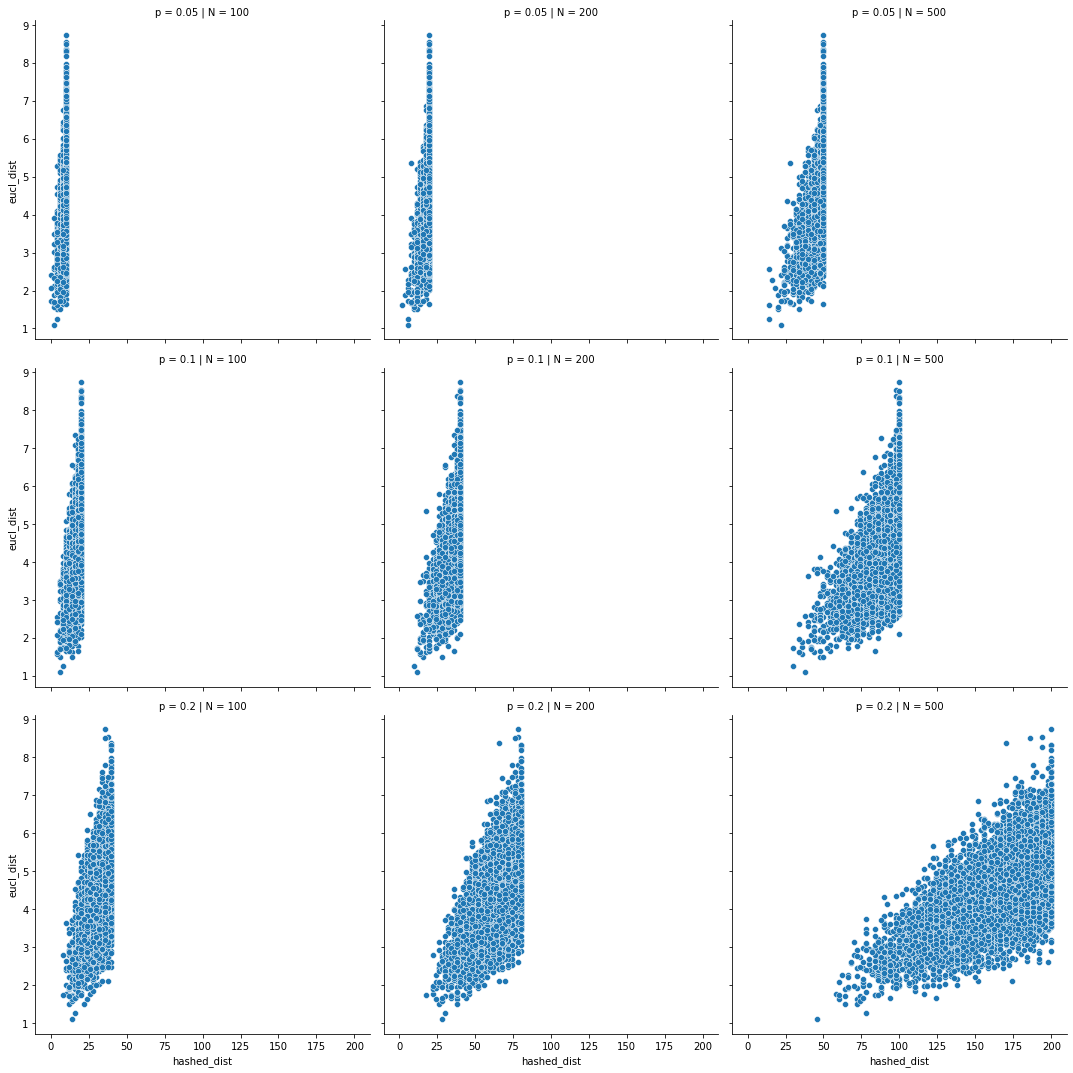

In [16]:
g = sns.relplot(x="hashed_dist", y="eucl_dist", col="N", row="p", data=res, kind="scatter")
g

### N = 100, p = 0.05, dim=10

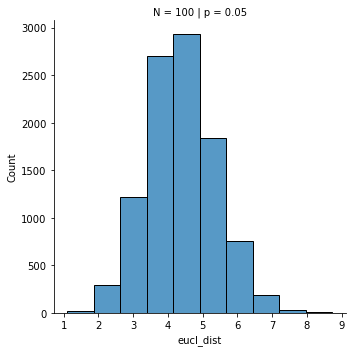

In [17]:
sns.displot(data=res[(res.N==100) &(res.p==0.05)], bins=10, kind="hist", x="eucl_dist", row="N", col="p")

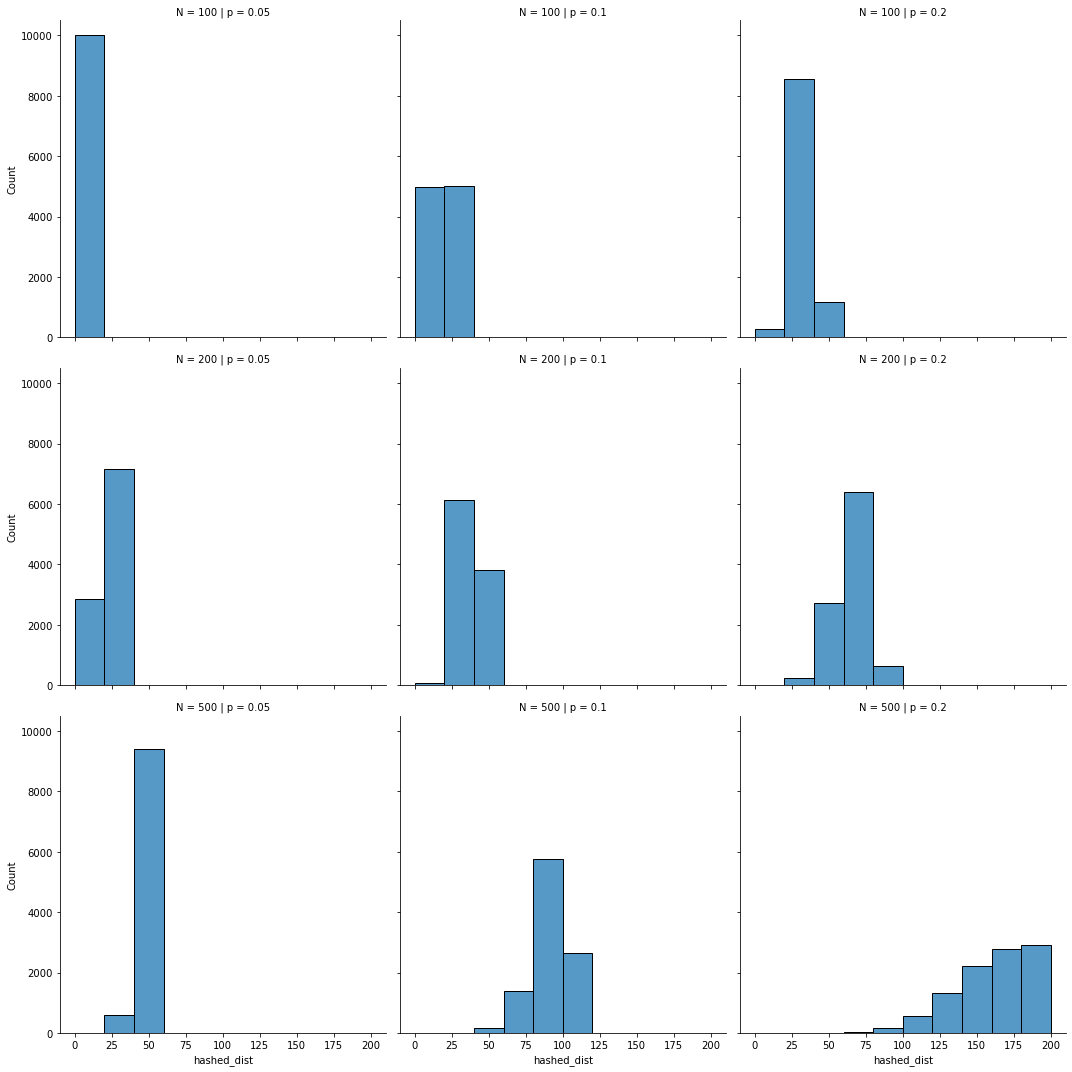

In [18]:
sns.displot(data=res, bins=10, kind="hist", x="hashed_dist", row="N", col="p")

In [19]:
avg = res.groupby(['hashed_dist', 'N', 'p'], as_index=False).mean()

std = res.groupby(['hashed_dist', 'N', 'p'], as_index=False).std()

In [20]:
N100_p005 = res[(res.N==100)&(res.p==0.05)]

### Joint plot

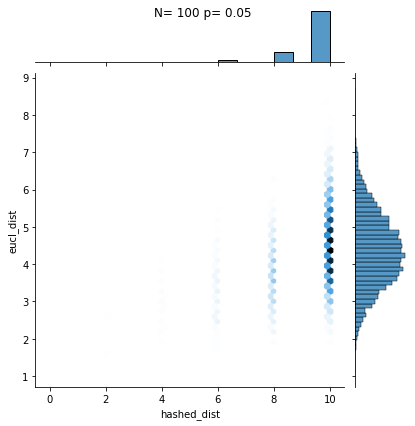

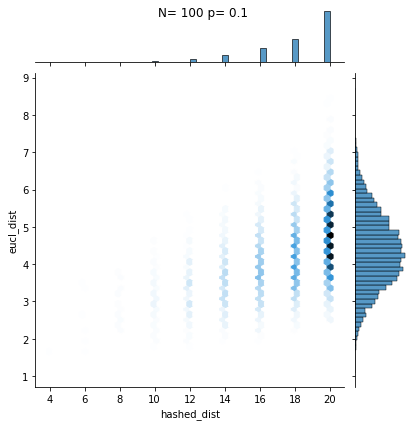

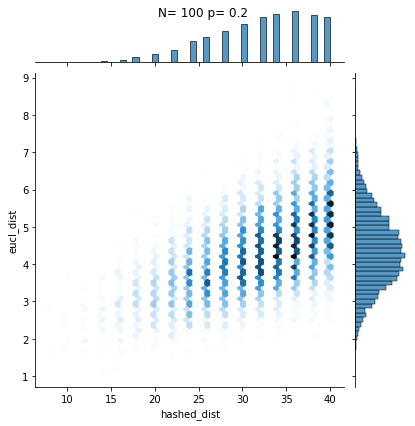

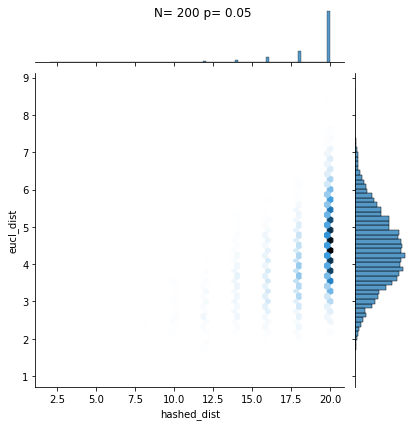

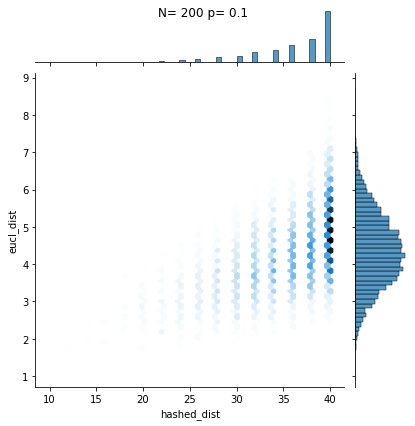

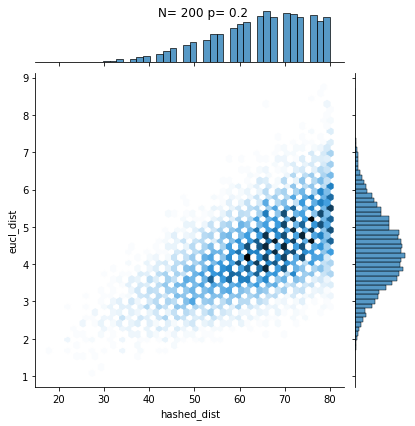

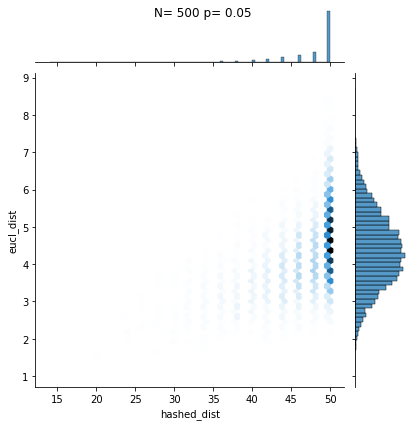

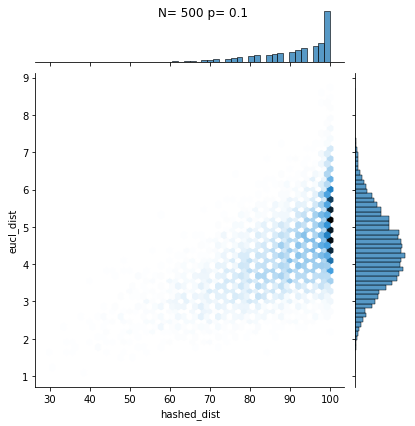

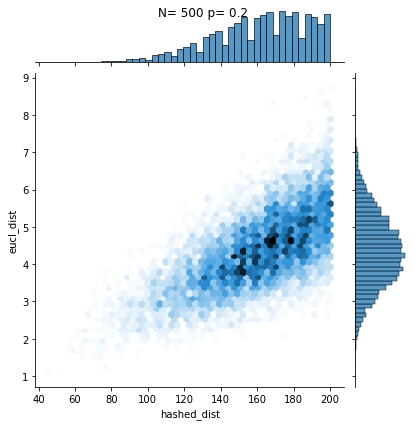

In [21]:
for N_ in [100,200,500]:
    for p_ in [0.05, 0.1, 0.2]:
        df = res[(res.N==N_)&(res.p==p_)]
        g = sns.jointplot(data=df, x="hashed_dist", y="eucl_dist", kind="hex")
        g.fig.suptitle('N= '+ str(N_)+ " p= "+ str(p_))
        g


### Catplot - hamming dist & euclidean dist

/Users/nika/miniconda/envs/am/lib/python3.9/site-packages/seaborn/categorical.py:3808: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


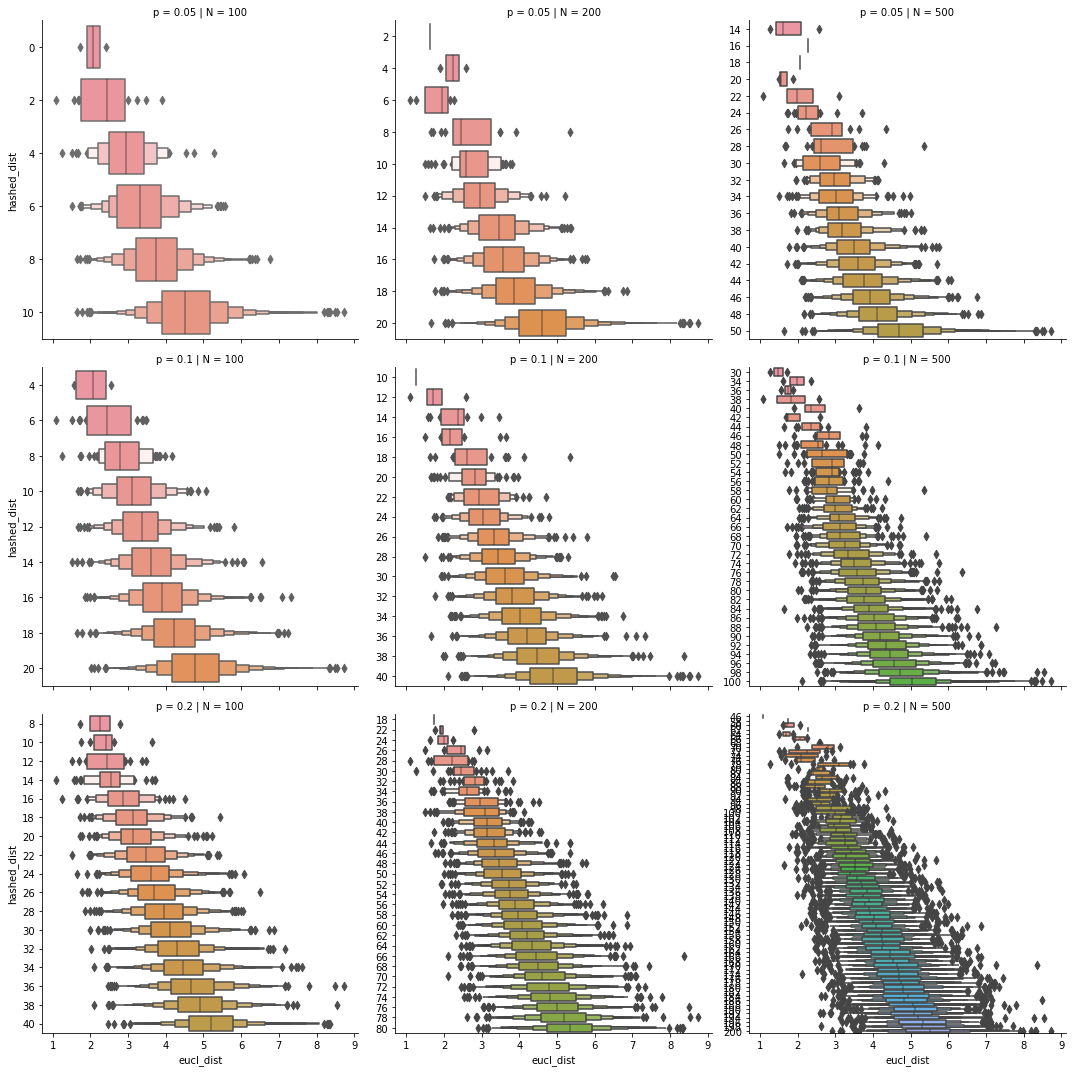

In [22]:
fig = sns.catplot(data=res, y="hashed_dist",x="eucl_dist", col="N", row="p", kind="boxen", sharey=False, orient="h")
fig

### Average hamming dist data - mean and standard deviation

In [23]:
mean_df = res.groupby(by=["N","p","hashed_dist"], as_index=False).mean()
std_df = res.groupby(by=["N","p","hashed_dist"], as_index=False).std()

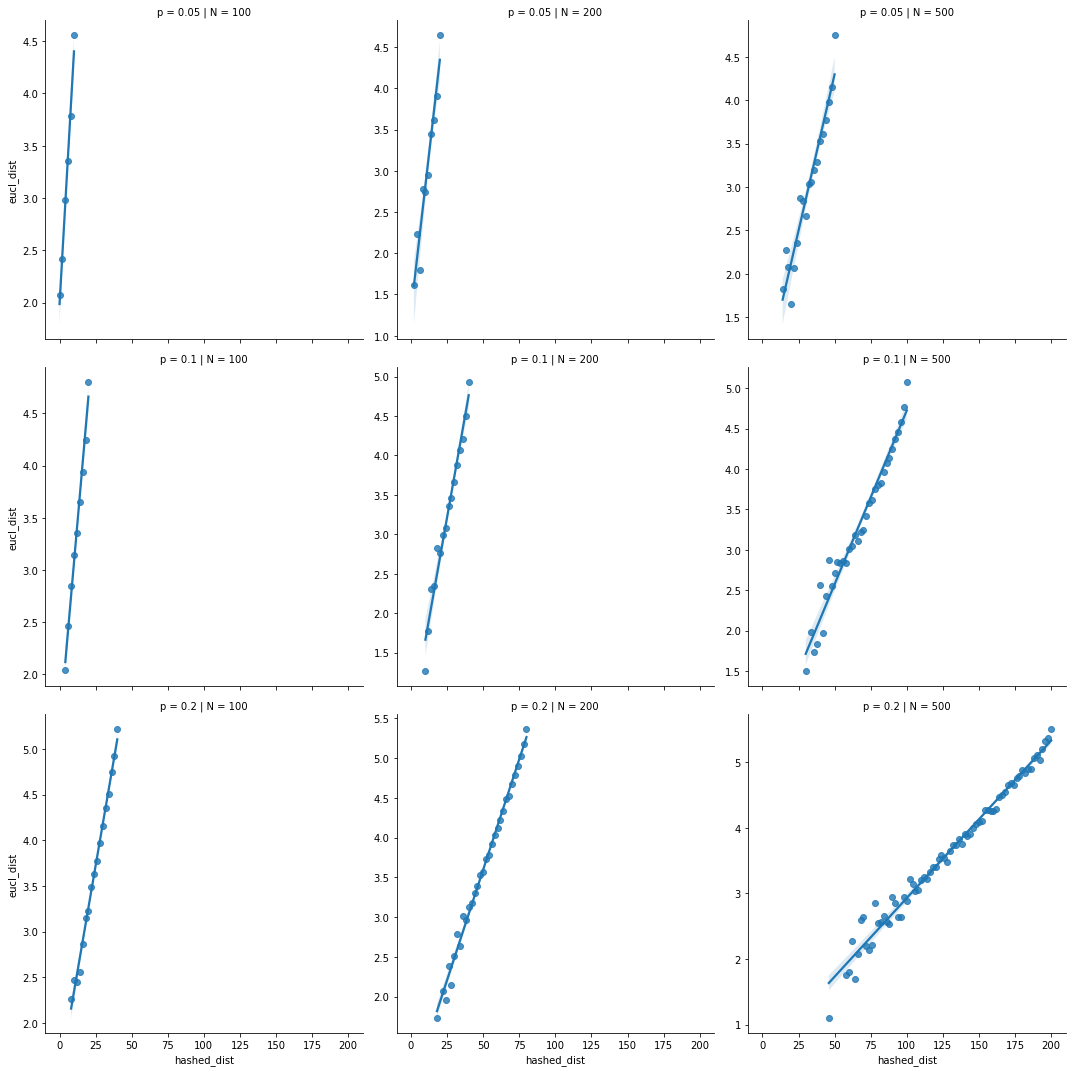

In [24]:
fig = sns.lmplot(data=mean_df, x="hashed_dist",y="eucl_dist", col="N", row="p", facet_kws={'sharey':False})


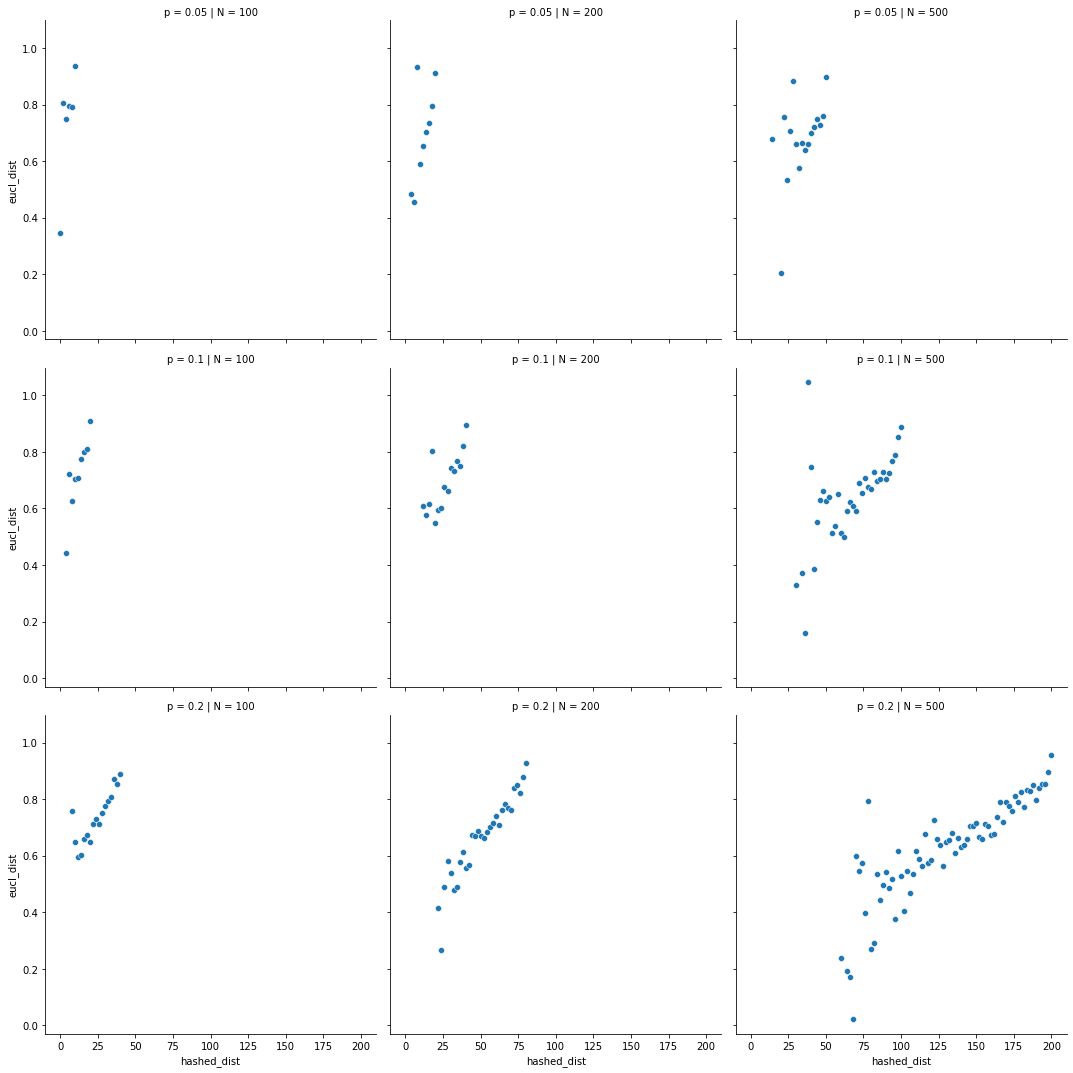

In [25]:
fig = sns.relplot(data=std_df, x="hashed_dist",y="eucl_dist", col="N", row="p")


### Euclidean distance < 100

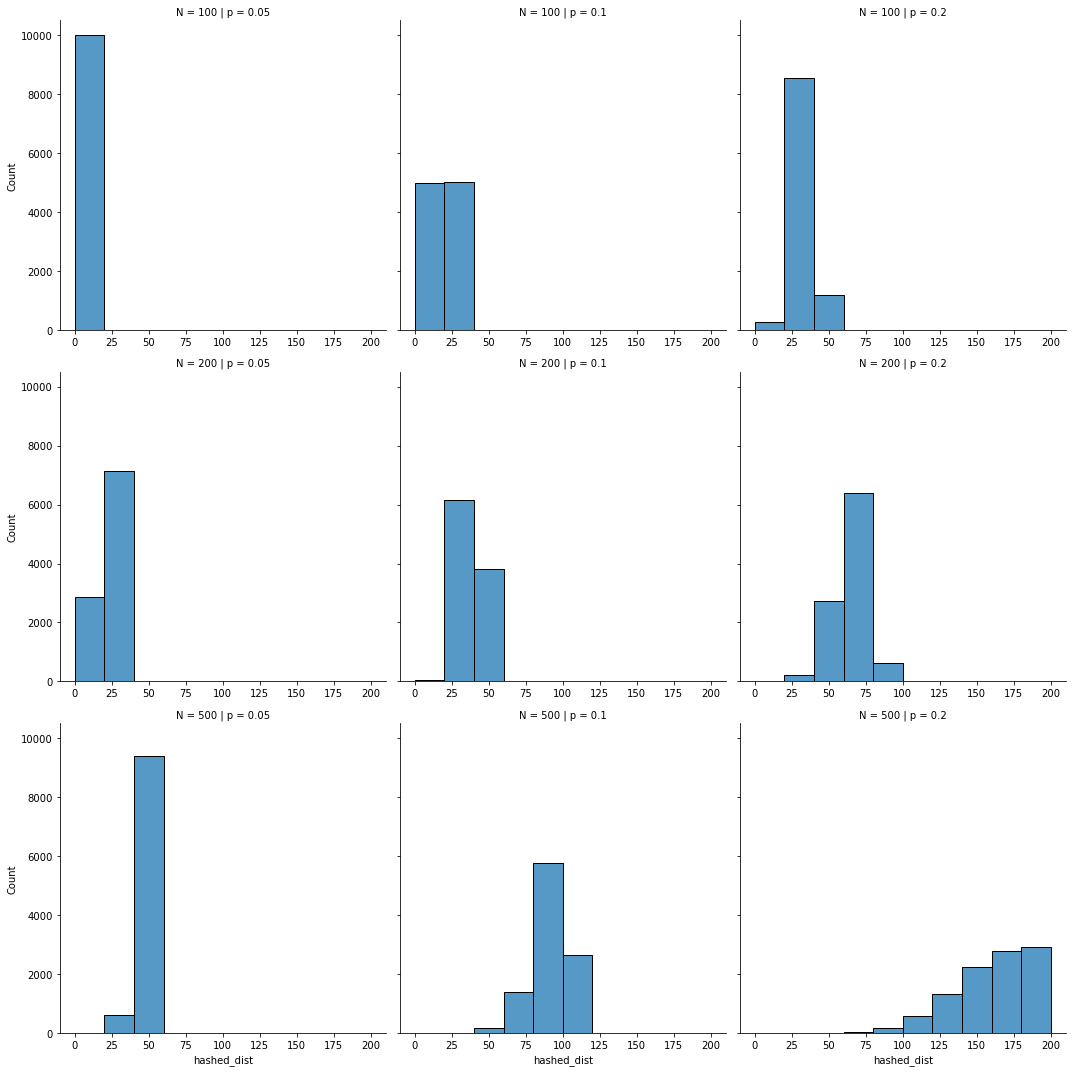

In [26]:
eucl_100 = res[res.eucl_dist < 100]

sns.displot(data=eucl_100, bins=10, kind="hist", x="hashed_dist", row="N", col="p", facet_kws={'sharex':False})

### S2 distance

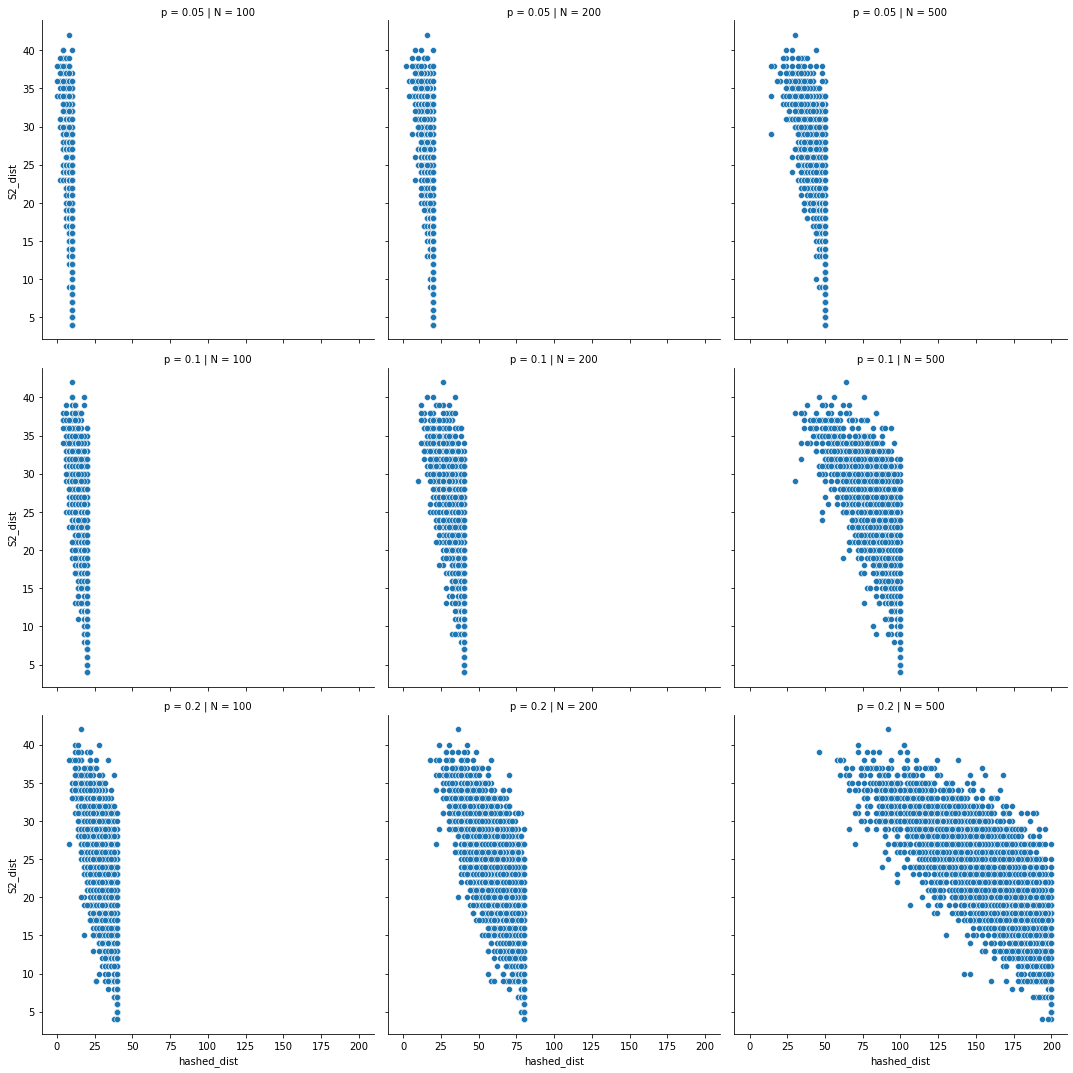

In [27]:
g = sns.relplot(x="hashed_dist", y="S2_dist", col="N", row="p", data=res, kind="scatter")
g

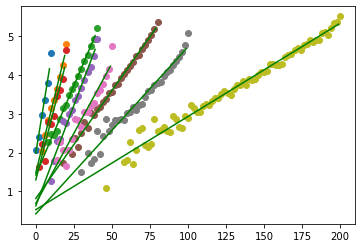

In [28]:
lin_m = {"N":[],"p":[],"intercept":[], "slope":[]}

for N_ in mean_df.N.unique():
    for p_ in mean_df.p.unique():
        avg_df = mean_df[(mean_df.N==N_)&(mean_df.p==p_)]

        linear_model=np.polyfit(avg_df.hashed_dist,avg_df.eucl_dist,1)
        linear_model_fn=np.poly1d(linear_model)
        lin_m["N"].append(N_)
        lin_m["p"].append(p_)
        lin_m["intercept"].append(linear_model[1])
        lin_m["slope"].append(linear_model[0])
        
        plt.scatter(x=avg_df.hashed_dist, y=avg_df.eucl_dist)
        x_s=np.arange(0,int(np.max(avg_df.hashed_dist)))
        plt.plot(x_s,linear_model_fn(x_s),color="green")

In [29]:
coeff_df = pd.DataFrame(lin_m)
coeff_df.to_csv("./lin_mod_params.csv")

In [30]:
coeff_df

N     p  intercept     slope
0  100  0.05   1.985565  0.241681
1  100  0.10   1.479982  0.159048
2  100  0.20   1.421914  0.092044
3  200  0.05   1.298335  0.152407
4  200  0.10   0.629593  0.103360
5  200  0.20   0.818366  0.055574
6  500  0.05   0.690823  0.072161
7  500  0.10   0.420983  0.043034
8  500  0.20   0.529621  0.024012

In [31]:
pred_df = []
for N_ in mean_df.N.unique():
    for p_ in mean_df.p.unique():
        avg_df = mean_df[(mean_df.N==N_)&(mean_df.p==p_)]
        linear_model=np.polyfit(avg_df.hashed_dist,avg_df.eucl_dist,1)
        slope = linear_model[0]
        intercept = linear_model[1]
#         avg_df.copy()["pred"] = slope * avg_df.hashed_dist + intercept
        avg_df = avg_df.assign(pred=lambda x: slope * x.hashed_dist + intercept)
        pred_df.append(avg_df)

pred_df = pd.concat(pred_df)

pred_df

N     p  hashed_dist  eucl_dist    S2_dist      pred
0    100  0.05            0   2.073351  36.000000  1.985565
1    100  0.05            2   2.412089  33.500000  2.468927
2    100  0.05            4   2.980033  31.526316  2.952289
3    100  0.05            6   3.357473  29.155914  3.435651
4    100  0.05            8   3.780559  26.726582  3.919013
..   ...   ...          ...        ...        ...       ...
211  500  0.20          192   5.035568  17.253788  5.139943
212  500  0.20          194   5.201606  16.309524  5.187967
213  500  0.20          196   5.325897  15.513514  5.235991
214  500  0.20          198   5.373027  13.989744  5.284015
215  500  0.20          200   5.512748  13.159544  5.332039

[216 rows x 6 columns]

In [32]:
np.average((avg_df["pred"] - avg_df.eucl_dist)**2)

0.022141634093646237

In [42]:
fname = './output/data_100N.csv'
df100 = pd.read_csv(fname)
# del df['Unnamed: 0']
df100.type = df100['type'].map({'known':'orig', 'new':'noisy'})

fname = './output/data_200N.csv'
df200 = pd.read_csv(fname)
# del df['Unnamed: 0']
df200.type = df200['type'].map({'known':'orig', 'new':'noisy'})

fname = './output/data_500N.csv'
df500 = pd.read_csv(fname)
# del df['Unnamed: 0']
df500.type = df500['type'].map({'known':'orig', 'new':'noisy'})

In [43]:
df_100_ = df100[(df100.type == "noisy") & ((df100.p == 0.05) | (df100.p == 0.1) | (df100.p == 0.2))]

df_200_ = df200[(df200.type == "noisy") & ((df200.p == 0.05) | (df200.p == 0.1) | (df200.p == 0.2))]

df_500_ = df500[(df500.type == "noisy") & ((df500.p == 0.05) | (df500.p == 0.1) | (df500.p == 0.2))]

df_all = pd.concat([df_100_,df_200_,df_500_])

In [44]:
N = set(df_all.N)
n = set(df_all.n)
d = set(df_all.d)
p = set(df_all.p)
U = set(df_all.U)
g = set(df_all.g)
N = np.sort(list(N))
n = np.sort(list(n))
d = np.sort(list(d))
p = np.sort(list(p))

# df_n = df_n.groupby(by=["N","n","d","p","U","g"], as_index=False)["errors"].mean()

In [45]:
df_all

Unnamed: 0  threshold    N   n  errors    p     k   type   g    U  \
64               64      4.220  100  64      20  0.2   579  noisy   4  5.0   
65               65      4.220  100  64      15  0.2   682  noisy   4  5.0   
66               66      4.220  100  64      19  0.2   627  noisy   4  5.0   
67               67      4.220  100  64      22  0.2   682  noisy   4  5.0   
68               68      4.220  100  64       3  0.2   148  noisy   4  5.0   
...             ...        ...  ...  ..     ...  ...   ...    ...  ..  ...   
5094395          27     -3.336  500  16      40  0.1  3949  noisy  64  3.0   
5094396          28     -3.336  500  16       1  0.1  1656  noisy  64  3.0   
5094397          29     -3.336  500  16       0  0.1  2166  noisy  64  3.0   
5094398          30     -3.336  500  16      40  0.1  3744  noisy  64  3.0   
5094399          31     -3.336  500  16      41  0.1  3873  noisy  64  3.0   

            d  seed  
64       0.01    27  
65       0.01    27  
66       0.01    27  
67       0.01    27  
68       0.01    27  
...       ...   ...  
5094395  0.10    27  
5094396  0.10    27  
5094397  0.10    27  
5094398  0.10    27  
5094399  0.10    27  

[9514496 rows x 12 columns]

In [46]:
list_df = []
list_df_2 = []

for N_ in N:
    for p_ in p:
        coeff_filt = coeff_df[(coeff_df.N==N_) & (coeff_df.p == p_)]
        df_filt = df_all[(df_all.N==N_) & (df_all.p==p_)]
        list_df.append(df_filt.assign(eucl_eq=lambda x: float(coeff_filt.slope) * x.errors + float(coeff_filt.intercept)))
        list_df_2.append(df_filt.assign(max_err=lambda x: 2 * x.p * x.N))

pred_all = pd.concat(list_df)

list_df = []

for N_ in N:
    for p_ in p:
        df_filt = pred_all[(pred_all.N==N_) & (pred_all.p==p_)]
        list_df.append(df_filt.assign(max_err=lambda x: 2 * x.p * x.N))
pred_all = pd.concat(list_df)


In [47]:
pred_all

Unnamed: 0  threshold    N    n  errors     p     k   type     g  \
896             512      3.180  100  512       5  0.05   186  noisy    16   
897             513      3.180  100  512       7  0.05   249  noisy    16   
898             514      3.180  100  512       8  0.05   303  noisy    16   
899             515      3.180  100  512       5  0.05   213  noisy    16   
900             516      3.180  100  512       5  0.05   597  noisy    16   
...             ...        ...  ...  ...     ...   ...   ...    ...   ...   
5094363         123  -1598.208  500   64       0  0.20  3545  noisy  8192   
5094364         124  -1598.208  500   64       0  0.20  3351  noisy  8192   
5094365         125  -1598.208  500   64       0  0.20  2131  noisy  8192   
5094366         126  -1598.208  500   64       0  0.20  2402  noisy  8192   
5094367         127  -1598.208  500   64       0  0.20  2092  noisy  8192   

            U     d  seed   eucl_eq  max_err  
896       3.9  0.10    27  3.193970     10.0  
897       3.9  0.10    27  3.677332     10.0  
898       3.9  0.10    27  3.919013     10.0  
899       3.9  0.10    27  3.193970     10.0  
900       3.9  0.10    27  3.193970     10.0  
...       ...   ...   ...       ...      ...  
5094363  32.0  0.05    27  0.529621    200.0  
5094364  32.0  0.05    27  0.529621    200.0  
5094365  32.0  0.05    27  0.529621    200.0  
5094366  32.0  0.05    27  0.529621    200.0  
5094367  32.0  0.05    27  0.529621    200.0  

[9514496 rows x 14 columns]

In [48]:
df_100_ = df100[(df100.type == "orig") & ((df100.p == 0.05) | (df100.p == 0.1) | (df100.p == 0.2))]

df_200_ = df200[(df200.type == "orig") & ((df200.p == 0.05) | (df200.p == 0.1) | (df200.p == 0.2))]

df_500_ = df500[(df500.type == "orig") & ((df500.p == 0.05) | (df500.p == 0.1) | (df500.p == 0.2))]

df_all_orig = pd.concat([df_100_,df_200_,df_500_])

In [49]:
df_all_orig

Unnamed: 0  threshold    N   n  errors    p     k  type   g    U  \
0                 0      4.220  100  64      20  0.2   579  orig   4  5.0   
1                 1      4.220  100  64      15  0.2   682  orig   4  5.0   
2                 2      4.220  100  64      19  0.2   627  orig   4  5.0   
3                 3      4.220  100  64      24  0.2  1348  orig   4  5.0   
4                 4      4.220  100  64       3  0.2   148  orig   4  5.0   
...             ...        ...  ...  ..     ...  ...   ...   ...  ..  ...   
5094379          11     -3.336  500  16      40  0.1  1951  orig  64  3.0   
5094380          12     -3.336  500  16       1  0.1  1656  orig  64  3.0   
5094381          13     -3.336  500  16       0  0.1     0  orig  64  3.0   
5094382          14     -3.336  500  16      40  0.1  3744  orig  64  3.0   
5094383          15     -3.336  500  16       2  0.1  1871  orig  64  3.0   

            d  seed  
0        0.01    27  
1        0.01    27  
2        0.01    27  
3        0.01    27  
4        0.01    27  
...       ...   ...  
5094379  0.10    27  
5094380  0.10    27  
5094381  0.10    27  
5094382  0.10    27  
5094383  0.10    27  

[9514496 rows x 12 columns]

In [50]:
list_df = []

for N_ in N:
    for p_ in p:
        coeff_filt = coeff_df[(coeff_df.N==N_) & (coeff_df.p == p_)]
        df_filt = df_all_orig[(df_all_orig.N==N_) & (df_all_orig.p==p_)]
        list_df.append(df_filt.assign(eucl_eq=lambda x: float(coeff_filt.slope) * x.errors + float(coeff_filt.intercept)))  
pred_all_orig = pd.concat(list_df)


list_df = []

for N_ in N:
    for p_ in p:
        df_filt = pred_all_orig[(pred_all_orig.N==N_) & (pred_all_orig.p==p_)]
        list_df.append(df_filt.assign(max_err=lambda x: 2 * x.p * x.N))
pred_all_orig = pd.concat(list_df)

In [51]:
df_Ug = pred_all_orig[(pred_all_orig.U == 4) & (pred_all_orig.g==1024)]

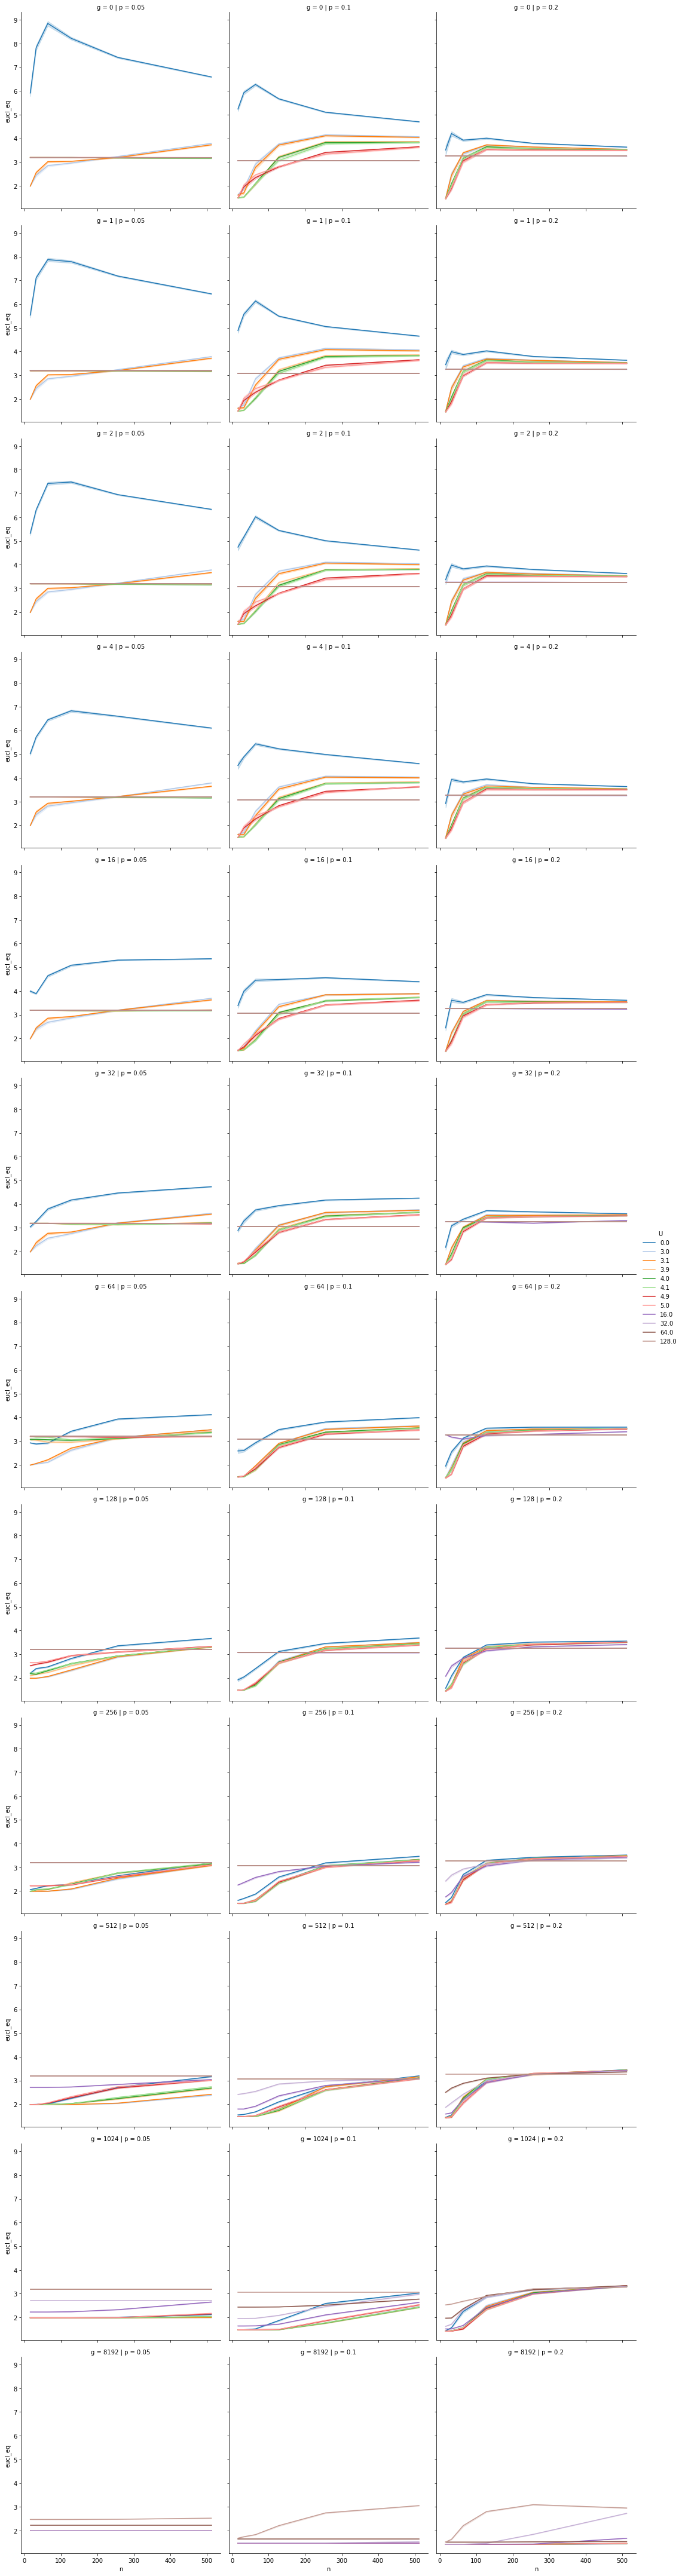

In [52]:
df_N100 = pred_all_orig[(pred_all_orig.N==100)]
g = sns.relplot(x="n", y="eucl_eq", col="p", row="g", hue="U", data=df_N100, kind="line", palette="tab20") #, ci=None
g

In [53]:
pred_all_orig.d = 0.0
preds_d = pd.concat((pred_all, pred_all_orig))

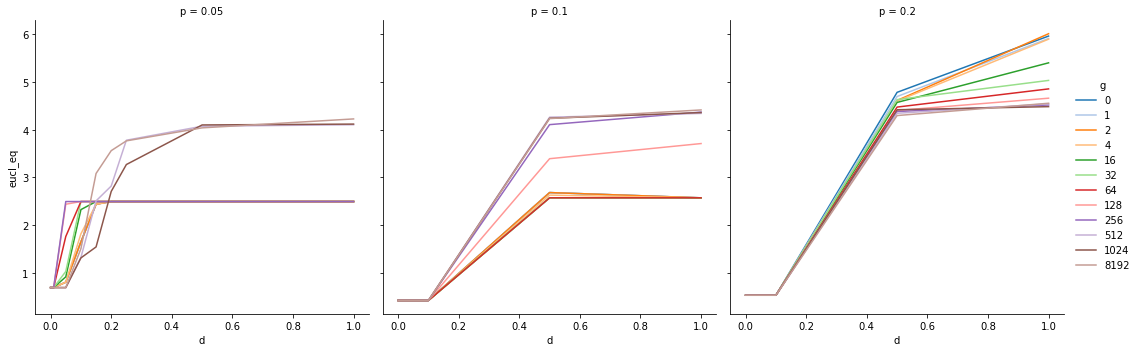

In [54]:
df_N100 = preds_d[(preds_d.N==500) & (preds_d.n==32) & (preds_d.U==16)]
g = sns.relplot(x="d", y="eucl_eq", col="p", hue="g", data=df_N100, kind="line", palette="tab20", ci=None) #, ci=None
g

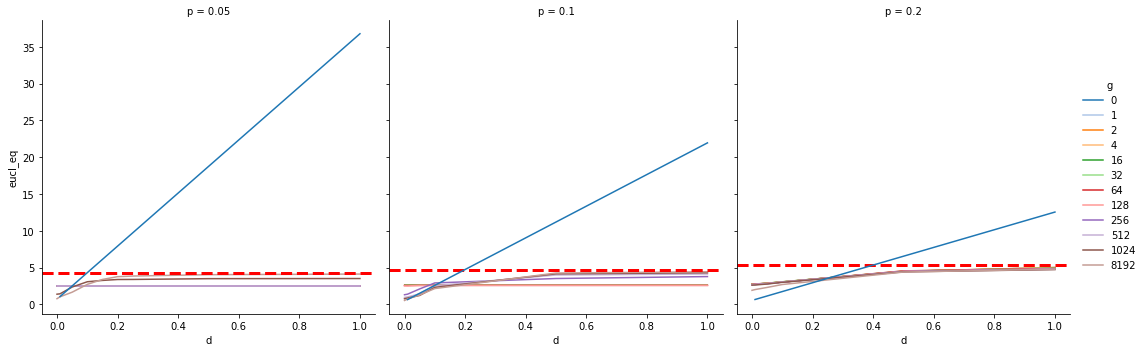

In [55]:
N_fixed = 500
df_N100 = preds_d[(preds_d.N==N_fixed) & (preds_d.n==256) & (preds_d.U==32)]

g = sns.relplot(x="d", y="eucl_eq", col="p", hue="g", data=df_N100, kind="line", palette="tab20", ci=None) #, ci=None

for j in range(len(p)):
#     g.axes[0,j].set_yscale('log')
    df_filt = coeff_df[(coeff_df.N==N_fixed) & (coeff_df.p==p[j])]
    g.axes[0,j].axhline(float(df_filt.slope)*2*N_fixed*p[j]+float(df_filt.intercept), ls='--', linewidth=3, color='red') #max error if 100% active vals are displaced
    d_pred = [float(df_filt.slope)*N_fixed*i+float(df_filt.intercept) for i in d]
    g.axes[0,j].plot(d, d_pred) #max error if 100% active vals are displaced

# find problem here


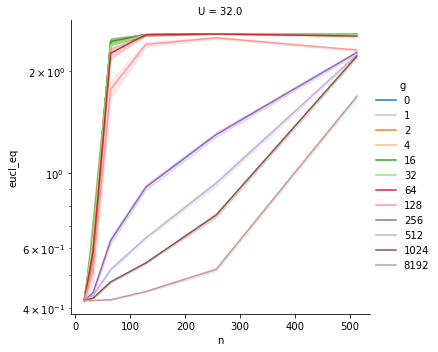

In [56]:
df_N500 = pred_all_orig[(pred_all_orig.N==500) & (pred_all_orig.p==0.1) & (pred_all_orig.U==32)]
g = sns.relplot(x="n", y="eucl_eq", row="U", hue="g", data=df_N500, kind="line", palette="tab20") #, ci=None
g.axes[0,0].set_yscale('log')
g

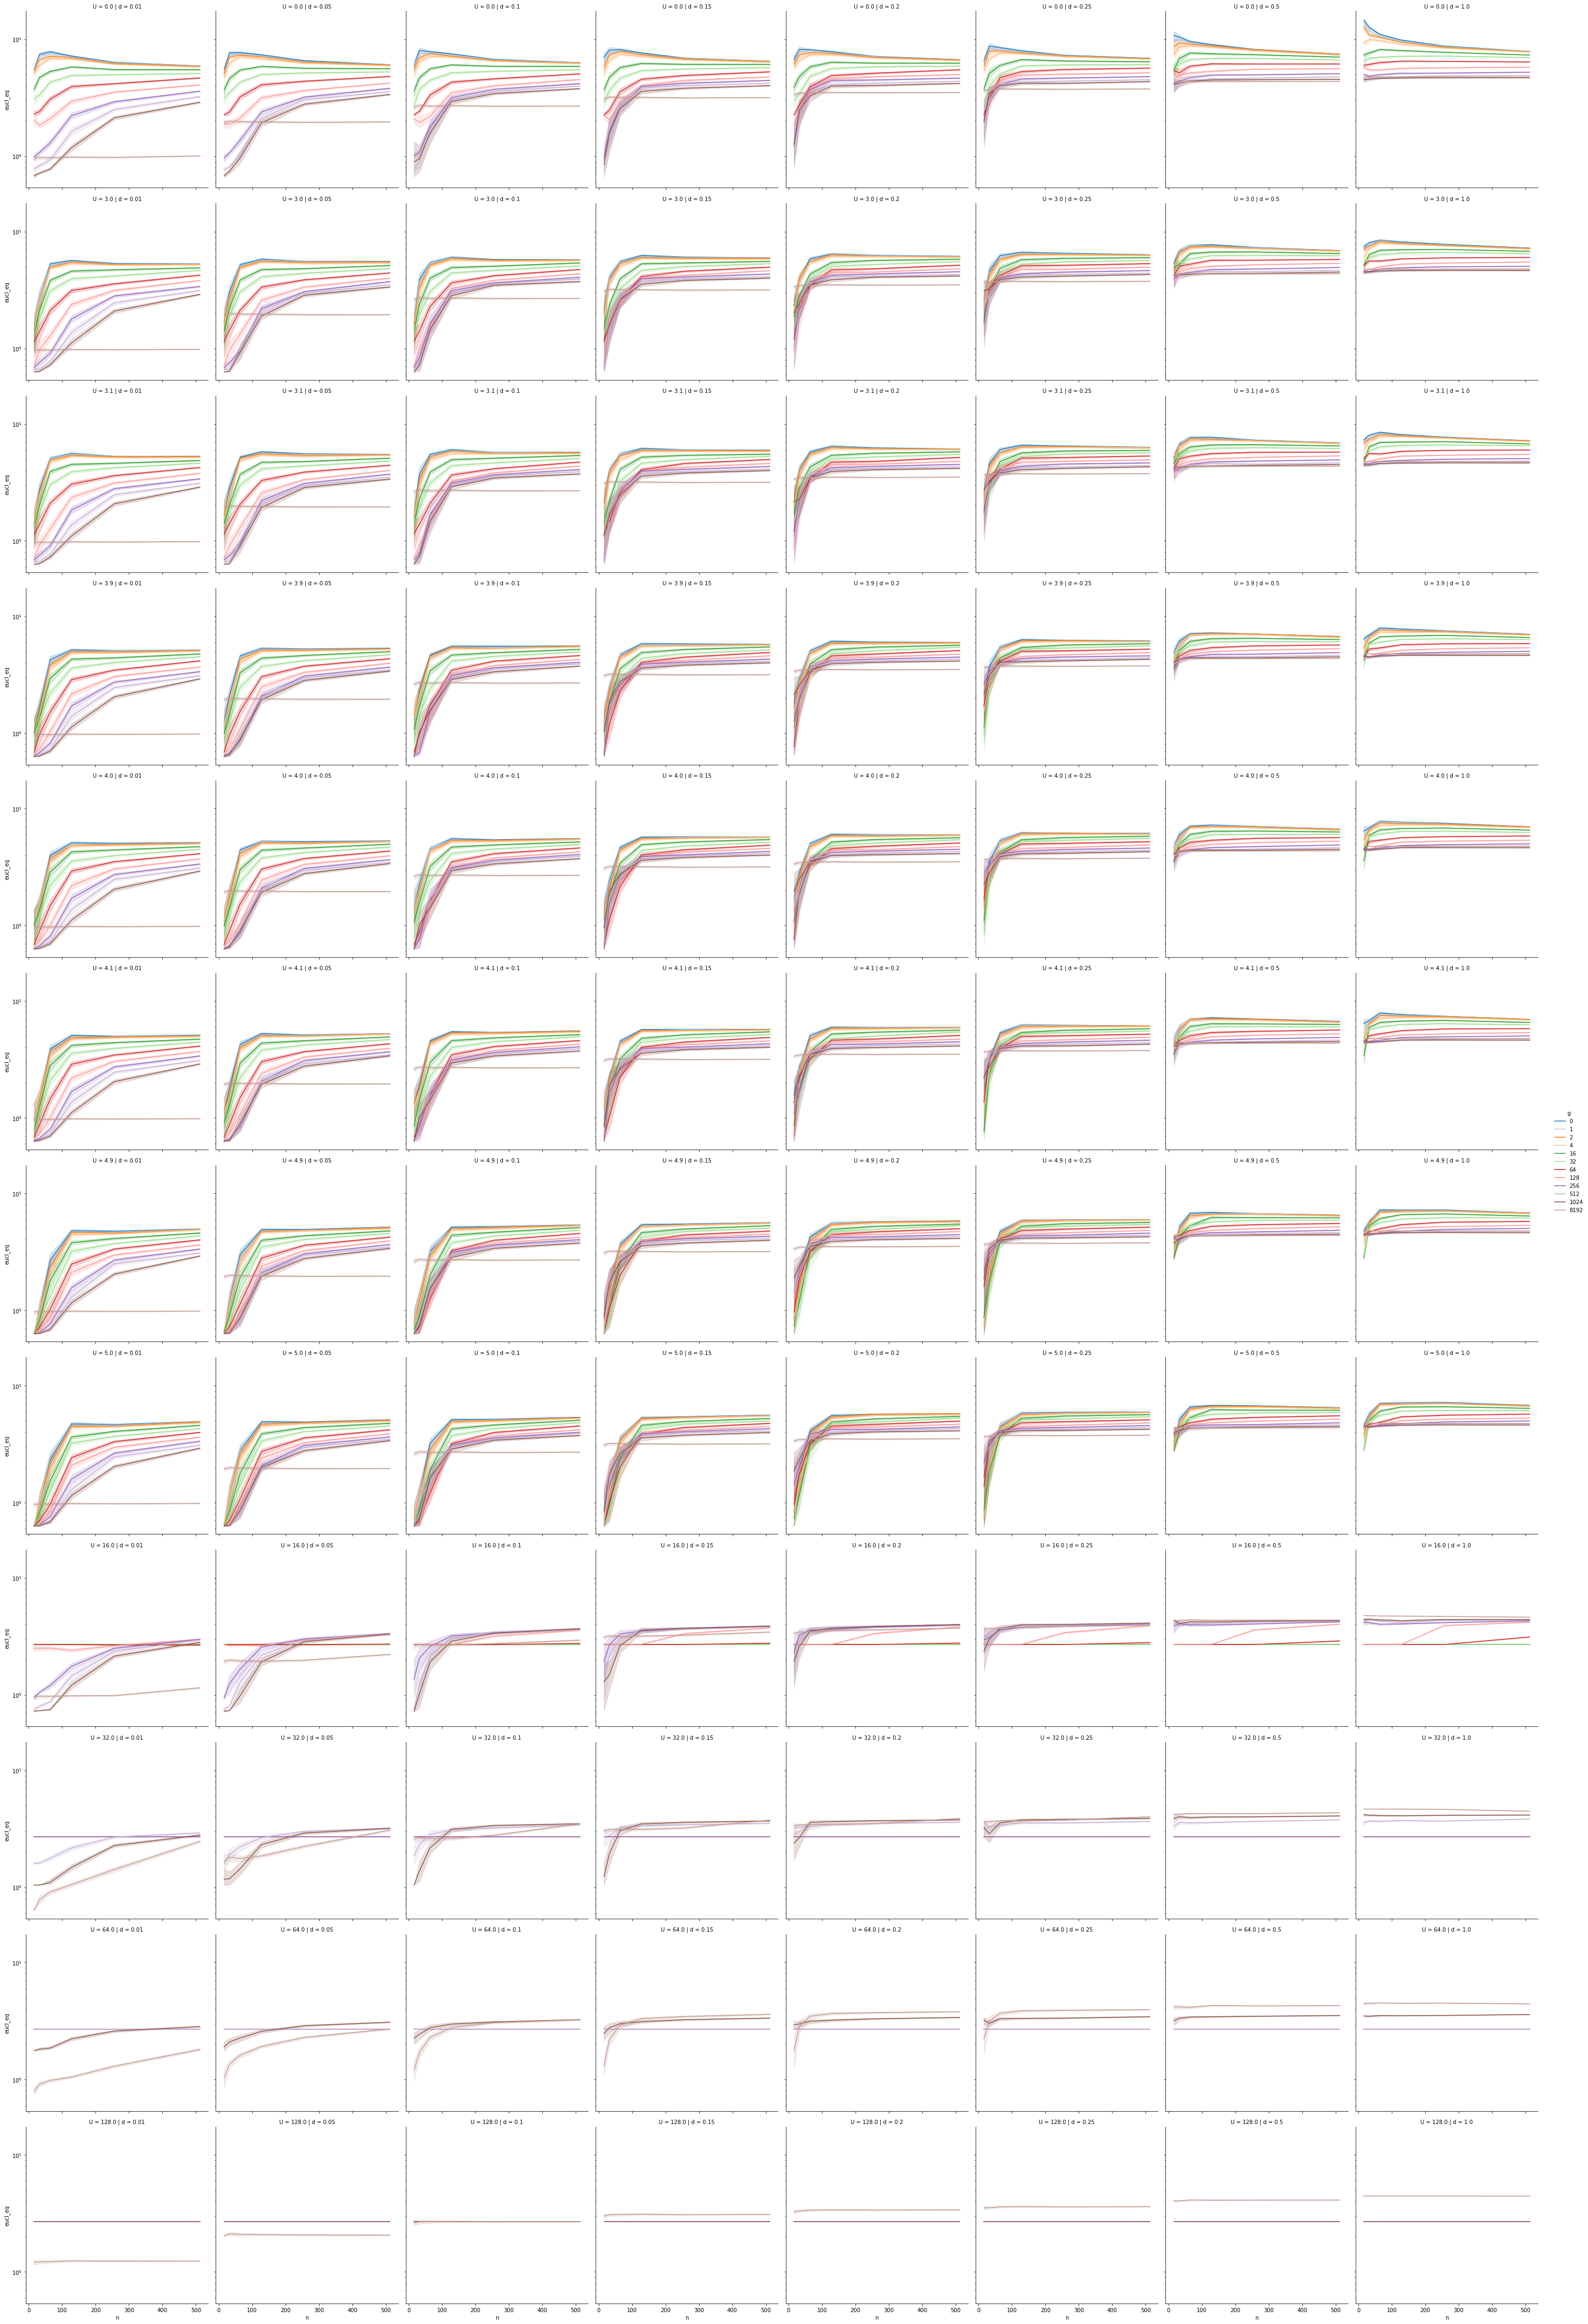

In [57]:
df_N500 = pred_all[(pred_all.N==200) & (pred_all.p==0.1)]
g = sns.relplot(x="n", y="eucl_eq", col="d", row="U", hue="g", data=df_N500, kind="line", palette="tab20") #, ci=None
g.axes[0,0].set_yscale('log')
g

### Make a DF with comparable d across all N

In [58]:
list_df = []

for N_ in coeff_df.N.unique():
    for p_ in coeff_df.p.unique():
        coeff_filt = coeff_df[(coeff_df.N==N_) & (coeff_df.p == p_)]
        df_filt = preds_d[(preds_d.N==N_) & (preds_d.p==p_)]
        list_df.append(df_filt.assign(d_eq=lambda x: float(coeff_filt.slope) * x.d*N_ + float(coeff_filt.intercept)))  
pred_d = pd.concat(list_df)


In [59]:
d_all = {}

for i in range(6):
    for N_ in coeff_df.N.unique():
        for p_ in coeff_df.p.unique():
            coeff_filt = coeff_df[(coeff_df.N==N_) & (coeff_df.p == p_)]
            d_all[i,N_,p_] = float(coeff_filt.slope)*i + float(coeff_filt.intercept)           
d_all

{(0, 100, 0.05): 1.9855650284118178,
 (0, 100, 0.1): 1.479982214246994,
 (0, 100, 0.2): 1.421914144256379,
 (0, 200, 0.05): 1.2983354191534053,
 (0, 200, 0.1): 0.6295932770077514,
 (0, 200, 0.2): 0.8183655661580683,
 (0, 500, 0.05): 0.690823274045266,
 (0, 500, 0.1): 0.42098279452729714,
 (0, 500, 0.2): 0.5296213606697815,
 (1, 100, 0.05): 2.227246056040397,
 (1, 100, 0.1): 1.639029811867383,
 (1, 100, 0.2): 1.513957694409276,
 (1, 200, 0.05): 1.4507425924003616,
 (1, 200, 0.1): 0.7329533653963706,
 (1, 200, 0.2): 0.8739399257632688,
 (1, 500, 0.05): 0.7629847443670632,
 (1, 500, 0.1): 0.4640170267513158,
 (1, 500, 0.2): 0.5536334508556069,
 (2, 100, 0.05): 2.468927083668976,
 (2, 100, 0.1): 1.798077409487772,
 (2, 100, 0.2): 1.6060012445621732,
 (2, 200, 0.05): 1.6031497656473181,
 (2, 200, 0.1): 0.8363134537849898,
 (2, 200, 0.2): 0.9295142853684695,
 (2, 500, 0.05): 0.8351462146888603,
 (2, 500, 0.1): 0.5070512589753344,
 (2, 500, 0.2): 0.5776455410414323,
 (3, 100, 0.05): 2.7106081

### Find min_i = highest intercept, max_i = minimum N\*p\*slope+intercept, min_j = min intercept, max_j = maximum N\*p\*slope+intercept

In [63]:
intercepts = []
Np_eq = []

for N in capacity.N.unique():
    for p in capacity.p.unique():
        coeff_filt = coeff_df[(coeff_df.N==N) & (coeff_df.p==p)]
        print("N,p: ", N,p)
        print(float(coeff_filt.intercept))
        print(N*p*float(coeff_filt.slope)+float(coeff_filt.intercept))
        intercepts.append(float(coeff_filt.intercept))
        Np_eq.append(N*p*float(coeff_filt.slope)+float(coeff_filt.intercept))

print("max, min ", np.max(intercepts), np.min(Np_eq))

min_i = np.max(intercepts)
max_i = np.min(Np_eq)

min_j =  np.min(intercepts)
max_j = np.max(Np_eq)

N,p:  100 0.05
1.9855650284118178
3.1939701665547133
N,p:  100 0.1
1.479982214246994
3.070458190450884
N,p:  100 0.2
1.421914144256379
3.2627851473143226
N,p:  200 0.05
1.2983354191534053
2.8224071516229694
N,p:  200 0.1
0.6295932770077514
2.696795044780136
N,p:  200 0.2
0.8183655661580683
3.041339950366091
N,p:  500 0.05
0.690823274045266
2.494860032090195
N,p:  500 0.1
0.42098279452729714
2.5726944057282286
N,p:  500 0.2
0.5296213606697815
2.930830379252324
max, min  1.9855650284118178 2.494860032090195


### Set several thresholds and find which is the smallest stored num of memories n above that threshold

In [64]:
# prendre plusieurs seuils
# chercher n le plus petit
def f(df):        
    df_t = df[df.eucl_eq > df.t]
    if len(df_t)==0:
        n_min = 512
    else:
        n_min = min(df_t.n)
        if n_min == 16:
            n_min = 0
        else:
            n_min = n_min / 2
    return(pd.Series(n_min))
    
# thresholds = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7]
# thresholds = np.linspace(min_i+0.001,max_i-0.001,100)

thresholds = np.linspace(min_j+0.001,max_j-0.001,100) #set to 1000 FIXME

dfs_list = []

mean_d = pred_d.groupby(["N","p","d_eq","U","g","n"], as_index=False).eucl_eq.mean()

for t in thresholds:
    mean_d_copy = mean_d.copy()
    mean_d_copy["t"] = t
    df_grouped = mean_d_copy.groupby(["N","p","d_eq","U","g","t"], as_index=False).apply(f)
#     df_grouped["t"] = t
    dfs_list.append(df_grouped)

capacity = pd.concat(dfs_list)
capacity.rename(columns = {0:'n'}, inplace = True)
capacity = capacity.reset_index()

In [65]:
max_i-min_i,max_j-min_j

(0.5092950036783772, 2.8418023527870253)

### Integrate over thresholds: 
- Group by all params except t, n and find sum and max of n

- multiply distance between 2 thresholds and (sum-max), divide by the length of the interval 

In [119]:
integration_thresholds = np.linspace(min_i+0.001,max_i-0.001,1000)
integration_capacity = capacity[(capacity.t>=min_i+0.001) & (capacity.t<max_i-0.001)]

sum_n = integration_capacity.groupby(["N","p","d_eq","U","g"], as_index=False).n.sum()
max_n = integration_capacity.groupby(["N","p","d_eq","U","g"], as_index=False).n.max()

max_n.rename(columns = {'n':'max_n'}, inplace = True)
sum_n.rename(columns = {'n':'sum_n'}, inplace = True)

sum_max = pd.merge(sum_n,max_n)

delta = thresholds[1]-thresholds[0]
sum_max["capacity"] = delta*(sum_max.sum_n-sum_max.max_n)/((max_i-0.001)-(min_i+0.001)) # divide by the length of the interval

sum_max

N     p       d_eq      U     g  sum_n  max_n  capacity
0      100  0.05   1.985565    0.0     0    0.0    0.0       0.0
1      100  0.05   1.985565    0.0     1    0.0    0.0       0.0
2      100  0.05   1.985565    0.0     2    0.0    0.0       0.0
3      100  0.05   1.985565    0.0     4    0.0    0.0       0.0
4      100  0.05   1.985565    0.0    16    0.0    0.0       0.0
...    ...   ...        ...    ...   ...    ...    ...       ...
10795  500  0.20  12.535666  128.0   128    0.0    0.0       0.0
10796  500  0.20  12.535666  128.0   256    0.0    0.0       0.0
10797  500  0.20  12.535666  128.0   512    0.0    0.0       0.0
10798  500  0.20  12.535666  128.0  1024    0.0    0.0       0.0
10799  500  0.20  12.535666  128.0  8192    0.0    0.0       0.0

[10800 rows x 8 columns]

### Integrate over distortion param d

In [67]:
d_list = np.sort(sum_max.d_eq.unique())

for N in sum_max.N.unique():
    for p in sum_max.p.unique():
        Np_filt = sum_max[(sum_max.N==N) & (sum_max.p==p)]
        d_min = Np_filt.d_eq.min()
        d_filt = Np_filt[Np_filt.d_eq==d_min]
        cap_max = d_filt[d_filt.capacity == d_filt.capacity.max()]
        print("U :", cap_max.U.unique(), "\n g: ", cap_max.g.unique())
        # print U,g list that give max capacity

U : [ 0.   3.   3.1  3.9  4.   4.1  4.9  5.  16.  32. ] 
 g:  [8192 1024]
U : [ 0.   3.   3.1  3.9  4.   4.1  4.9  5.  16.  32.  64. ] 
 g:  [8192]
U : [ 0.   3.   3.1  3.9  4.   4.1  4.9  5.  16.  64. ] 
 g:  [8192]
U : [  0.    3.    3.1   3.9   4.    4.1   4.9   5.   16.   32.   64.  128. ] 
 g:  [8192 1024]
U : [  0.    3.    3.1   3.9   4.    4.1   4.9   5.   16.   64.  128. ] 
 g:  [8192]
U : [  3.    3.1   3.9   4.    4.1   4.9   5.  128. ] 
 g:  [8192]
U : [  0.    3.    3.1   3.9   4.    4.1   4.9   5.   16.   32.   64.  128. ] 
 g:  [1024 8192  512   64  128  256]
U : [  0.    3.    3.1   3.9   4.    4.1   4.9   5.   16.   32.   64.  128. ] 
 g:  [8192]
U : [ 16.  32.  64. 128.] 
 g:  [8192]


In [68]:
for N in sum_max.N.unique():
    for p in sum_max.p.unique():
        Np_filt = sum_max[(sum_max.N==N) & (sum_max.p==p)]
        d_min = Np_filt.d_eq.min()
        d_max = Np_filt.d_eq.max()
        print(N,p,d_min,d_max)

100 0.05 1.9855650284118178 26.153667791269733
100 0.1 1.479982214246994 17.38474197628589
100 0.2 1.421914144256379 10.626269159546096
200 0.05 1.2983354191534053 31.77977006854469
200 0.1 0.6295932770077514 21.301610954731593
200 0.2 0.8183655661580683 11.93323748719818
500 0.05 0.690823274045266 36.77155843494385
500 0.1 0.42098279452729714 21.938098906536613
500 0.2 0.5296213606697815 12.535666453582493


## Integration over d

In [69]:
for N in np.sort(sum_max.N.unique()):
    for p in np.sort(sum_max.p.unique()):
        cf = coeff_df[(coeff_df.N==N) & (coeff_df.p==p)]
        print(N,p,float(cf.slope*N*0.15+cf.intercept))

100 0.05 5.610780442840505
100 0.1 3.8656961785528288
100 0.2 2.8025673965498363
200 0.05 5.870550616562097
200 0.1 3.7303959286663275
200 0.2 2.4855963543140853
500 0.05 6.102933548180053
500 0.1 3.6485502113286943
500 0.2 2.3305281246066882


In [70]:
for N in np.sort(sum_max.N.unique()):
    for p in np.sort(sum_max.p.unique()):
        cf = coeff_df[(coeff_df.N==N) & (coeff_df.p==p)]
        print(N,p,float(cf.slope*N*0.2+cf.intercept))

100 0.05 6.819185580983402
100 0.1 4.660934166654774
100 0.2 3.2627851473143226
200 0.05 7.394622349031662
200 0.1 4.763996812552521
200 0.2 3.041339950366091
500 0.05 7.9069703062249825
500 0.1 4.72440601692916
500 0.2 2.930830379252324


In [71]:
for N in np.sort(sum_max.N.unique()):
    for p in np.sort(sum_max.p.unique()):
        cf = coeff_df[(coeff_df.N==N) & (coeff_df.p==p)]
        print(N,p,float(cf.slope*N*0.25+cf.intercept))

100 0.05 8.027590719126296
100 0.1 5.456172154756718
100 0.2 3.7230028980788084
200 0.05 8.918694081501226
200 0.1 5.797597696438713
200 0.2 3.5970835464180966
500 0.05 9.711007064269912
500 0.1 5.800261822529626
500 0.2 3.5311326338979594


In [72]:
for N in np.sort(sum_max.N.unique()):
    for p in np.sort(sum_max.p.unique()):
        print("N, p: ",N,p)
        s=" "
        for d in np.sort(pred_d.d.unique()):
            if len(pred_d[(pred_d.d==d)&(pred_d.N==N)&(pred_d.p==p)]) > 0:
                d_eq = float(pred_d[(pred_d.d==d)&(pred_d.N==N)&(pred_d.p==p)].d_eq.unique())
                s=s+"d: "+str(d)+" d_eq: "+str(d_eq)+";"
            
        print(s)
        
#2.227246056040397 3.5311326338979594

N, p:  100 0.05
 d: 0.0 d_eq: 1.9855650284118178;d: 0.01 d_eq: 2.227246056040397;d: 0.05 d_eq: 3.1939701665547133;d: 0.1 d_eq: 4.4023753046976095;d: 0.15 d_eq: 5.610780442840505;d: 0.2 d_eq: 6.819185580983401;d: 0.25 d_eq: 8.027590719126296;d: 0.5 d_eq: 14.069616409840776;d: 1.0 d_eq: 26.153667791269733;
N, p:  100 0.1
 d: 0.0 d_eq: 1.479982214246994;d: 0.01 d_eq: 1.639029811867383;d: 0.05 d_eq: 2.275220202348939;d: 0.1 d_eq: 3.070458190450884;d: 0.15 d_eq: 3.8656961785528288;d: 0.2 d_eq: 4.660934166654774;d: 0.25 d_eq: 5.456172154756718;d: 0.5 d_eq: 9.432362095266443;d: 1.0 d_eq: 17.38474197628589;
N, p:  100 0.2
 d: 0.0 d_eq: 1.421914144256379;d: 0.01 d_eq: 1.513957694409276;d: 0.05 d_eq: 1.8821318950208648;d: 0.1 d_eq: 2.3423496457853505;d: 0.15 d_eq: 2.8025673965498363;d: 0.2 d_eq: 3.2627851473143226;d: 0.25 d_eq: 3.7230028980788084;d: 0.5 d_eq: 6.024091651901237;d: 1.0 d_eq: 10.626269159546096;
N, p:  200 0.05
 d: 0.0 d_eq: 1.2983354191534053;d: 0.01 d_eq: 1.6031497656473181;d: 0.

In [73]:
d_list=np.array([0.01,0.05,0.1,0.15,0.2,0.25])
d_eqs = []
d_min_list = []
d_max_list = []

for N in np.sort(sum_max.N.unique()):
    for p in np.sort(sum_max.p.unique()):
        Np_list = []
        for d in np.sort(d_list):
#             d_eq = float(pred_d[(pred_d.d==d)&(pred_d.N==N)&(pred_d.p==p)].d_eq.unique())
            df = coeff_df[(coeff_df.N==N) & (coeff_df.p==p)]
            d_eq = float(d*N*df.slope + df.intercept)
            d_eqs.append(d_eq)
            Np_list.append(d_eq)
        d_min = np.min(Np_list)
        d_max = np.max(Np_list)
        d_min_list.append(d_min)
        d_max_list.append(d_max)
    
d_min = np.max(d_min_list)
d_max = np.min(d_max_list)
print(d_min,d_max)

2.227246056040397 3.5311326338979594


In [169]:
def extend_cap_left(df):
    d_eq_min = np.min(df.d_eq)
    filt = df[df.d_eq==d_eq_min]
    cap = float(filt.capacity)
    return(pd.Series(cap))

cap_left = sum_max.groupby(['N','p','U','g'],as_index=False).apply(extend_cap_left)
cap_left.rename(columns = {0:'capacity'}, inplace = True)
cap_left['d_eq']=0

sum_max_augmented = pd.concat((cap_left,sum_max))

In [170]:
def integrate_d(df):
    dfd = df.sort_values(by=['d_eq'])
    diff = np.diff(dfd.d_eq)
    result = np.sum(np.array(dfd.capacity)[1:]*diff)/(np.array(dfd.d_eq)[-1]-np.array(dfd.d_eq)[0])
    return(pd.Series(result))

In [174]:
integration_capacity = sum_max_augmented[(sum_max_augmented.d_eq<d_max+0.001)]

# integration_capacity = integration_capacity[(integration_capacity.N!=500)] #FIXME
sum_max_d = integration_capacity.groupby(["N","p","U","g"], as_index=False).apply(integrate_d)
sum_max_d.rename(columns = {0:'c'}, inplace = True)

In [107]:
len(preds_d[(preds_d.N==500)&(preds_d.p==0.2)].groupby([ 'n', 'd']).mean())

36

In [118]:
len(preds_d[(preds_d.N==200)&(preds_d.p==0.1)].groupby([ 'n', 'd']).mean())

54

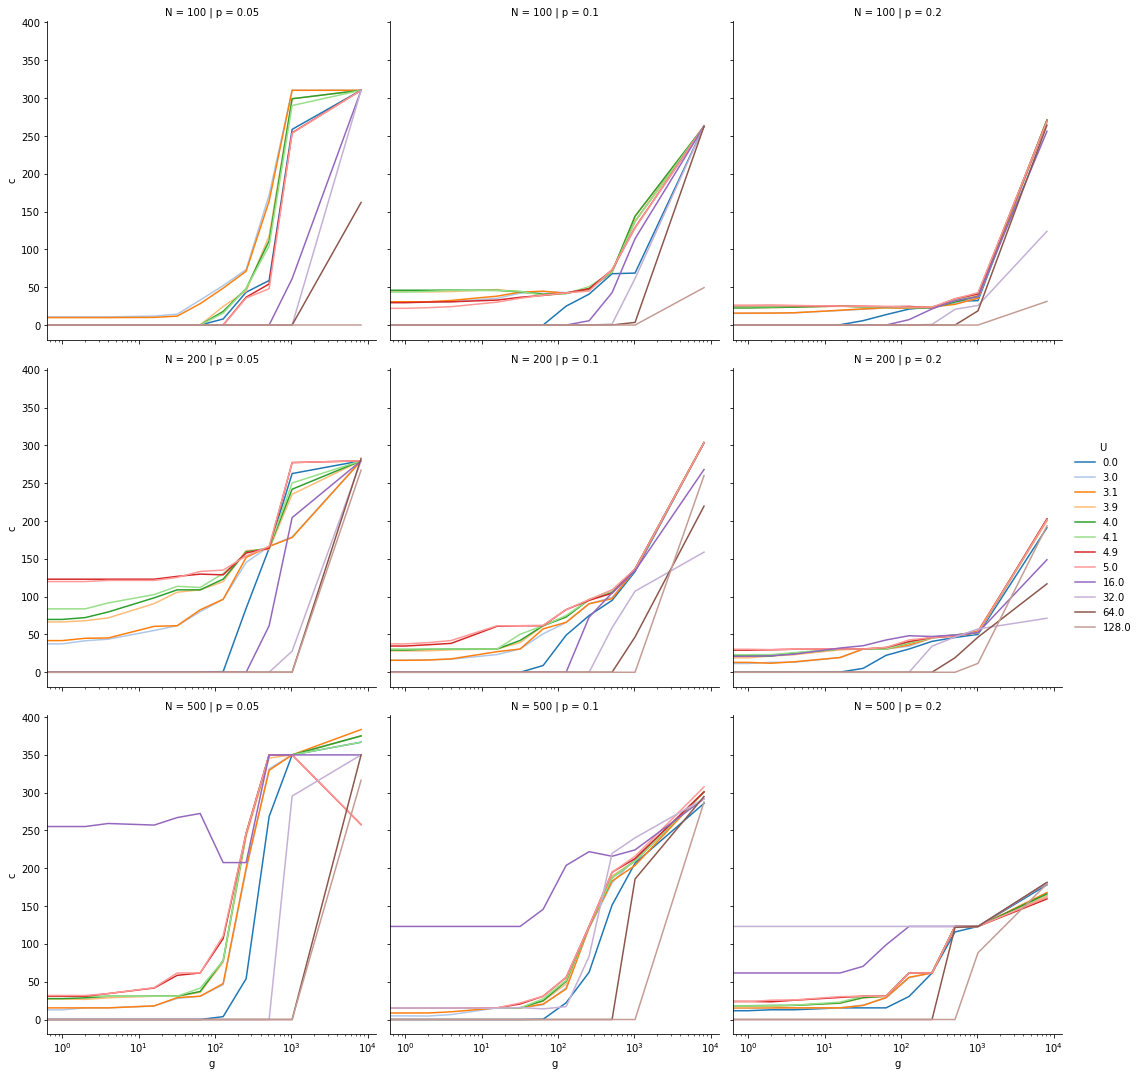

In [175]:
g = sns.relplot(x="g", y="c", col="p", row="N", hue="U", data=sum_max_d, kind="line", palette="tab20") #, ci=None
g.axes[0,0].set_xscale('log')

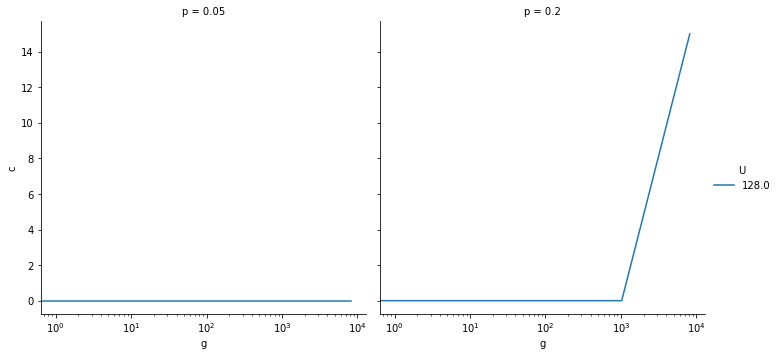

In [235]:
U128_df = sum_max_d[sum_max_d.U==128]
g = sns.relplot(x="g", y="c", col="p", hue="U", data=U128_df, kind="line", palette="tab20") #, ci=None
g.axes[0,0].set_xscale('log')

In [ ]:
# capacite en fonction d d_eq avant l'integration

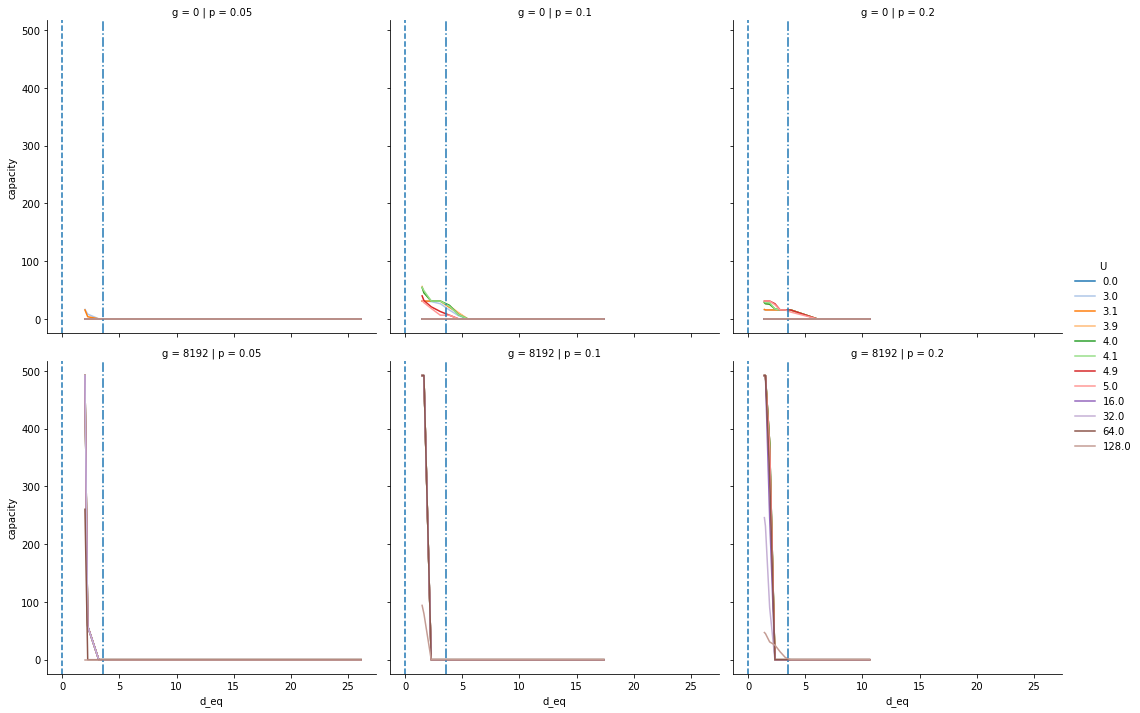

In [178]:
N=100
# p=0.2

cap_filt = sum_max[(sum_max.N==N)&((sum_max.g==0)|(sum_max.g==8192))]

g = sns.relplot(x="d_eq", y="capacity", col="p", row="g", hue="U", data=cap_filt, kind="line", palette="tab20", facet_kws={'sharey':True}) #, ci=None
# g.axes[0,0].set_yscale('log')
d_list = np.sort(cap_filt.d_eq.unique())

for i in range(g.axes.shape[0]):
    for j in range(g.axes.shape[1]):
        g.axes[i,j].axvline(x=0,linestyle='--')
#         coeff_filt = coeff_df[(coeff_df.N==N) & (coeff_df.p==p)]
#         g.axes[i,j].axvline(x=float(coeff_filt.intercept),linestyle='-')
        g.axes[i,j].axvline(x=d_max, linestyle='-.')
#         g.axes[i,j].axvline(x=min_i, color='r')
#         g.axes[i,j].axvline(x=max_i, color='g')
#         g.axes[i,j].axvline(x=float(coeff_filt.slope)*N*p+float(coeff_filt.intercept), linestyle=':')

### Include d=0

In [ ]:
N=500
p=0.2

cap_filt = capacity[(capacity.N==N) & (capacity.p==p)]

g = sns.relplot(x="t", y="n", col="d_eq", row="g", hue="U", data=cap_filt, kind="line", palette="tab20") #, ci=None
# g.axes[0,0].set_yscale('log')
d_list = np.sort(cap_filt.d_eq.unique())

for i in range(g.axes.shape[0]):
    for j in range(g.axes.shape[1]):
        g.axes[i,j].axvline(x=min_j,linestyle='--')
        coeff_filt = coeff_df[(coeff_df.N==N) & (coeff_df.p==p)]
        g.axes[i,j].axvline(x=float(coeff_filt.intercept),linestyle='-')
        g.axes[i,j].axvline(x=max_j, linestyle='-.')
        g.axes[i,j].axvline(x=min_i, color='r')
        g.axes[i,j].axvline(x=max_i, color='g')
        g.axes[i,j].axvline(x=float(coeff_filt.slope)*N*p+float(coeff_filt.intercept), linestyle=':')

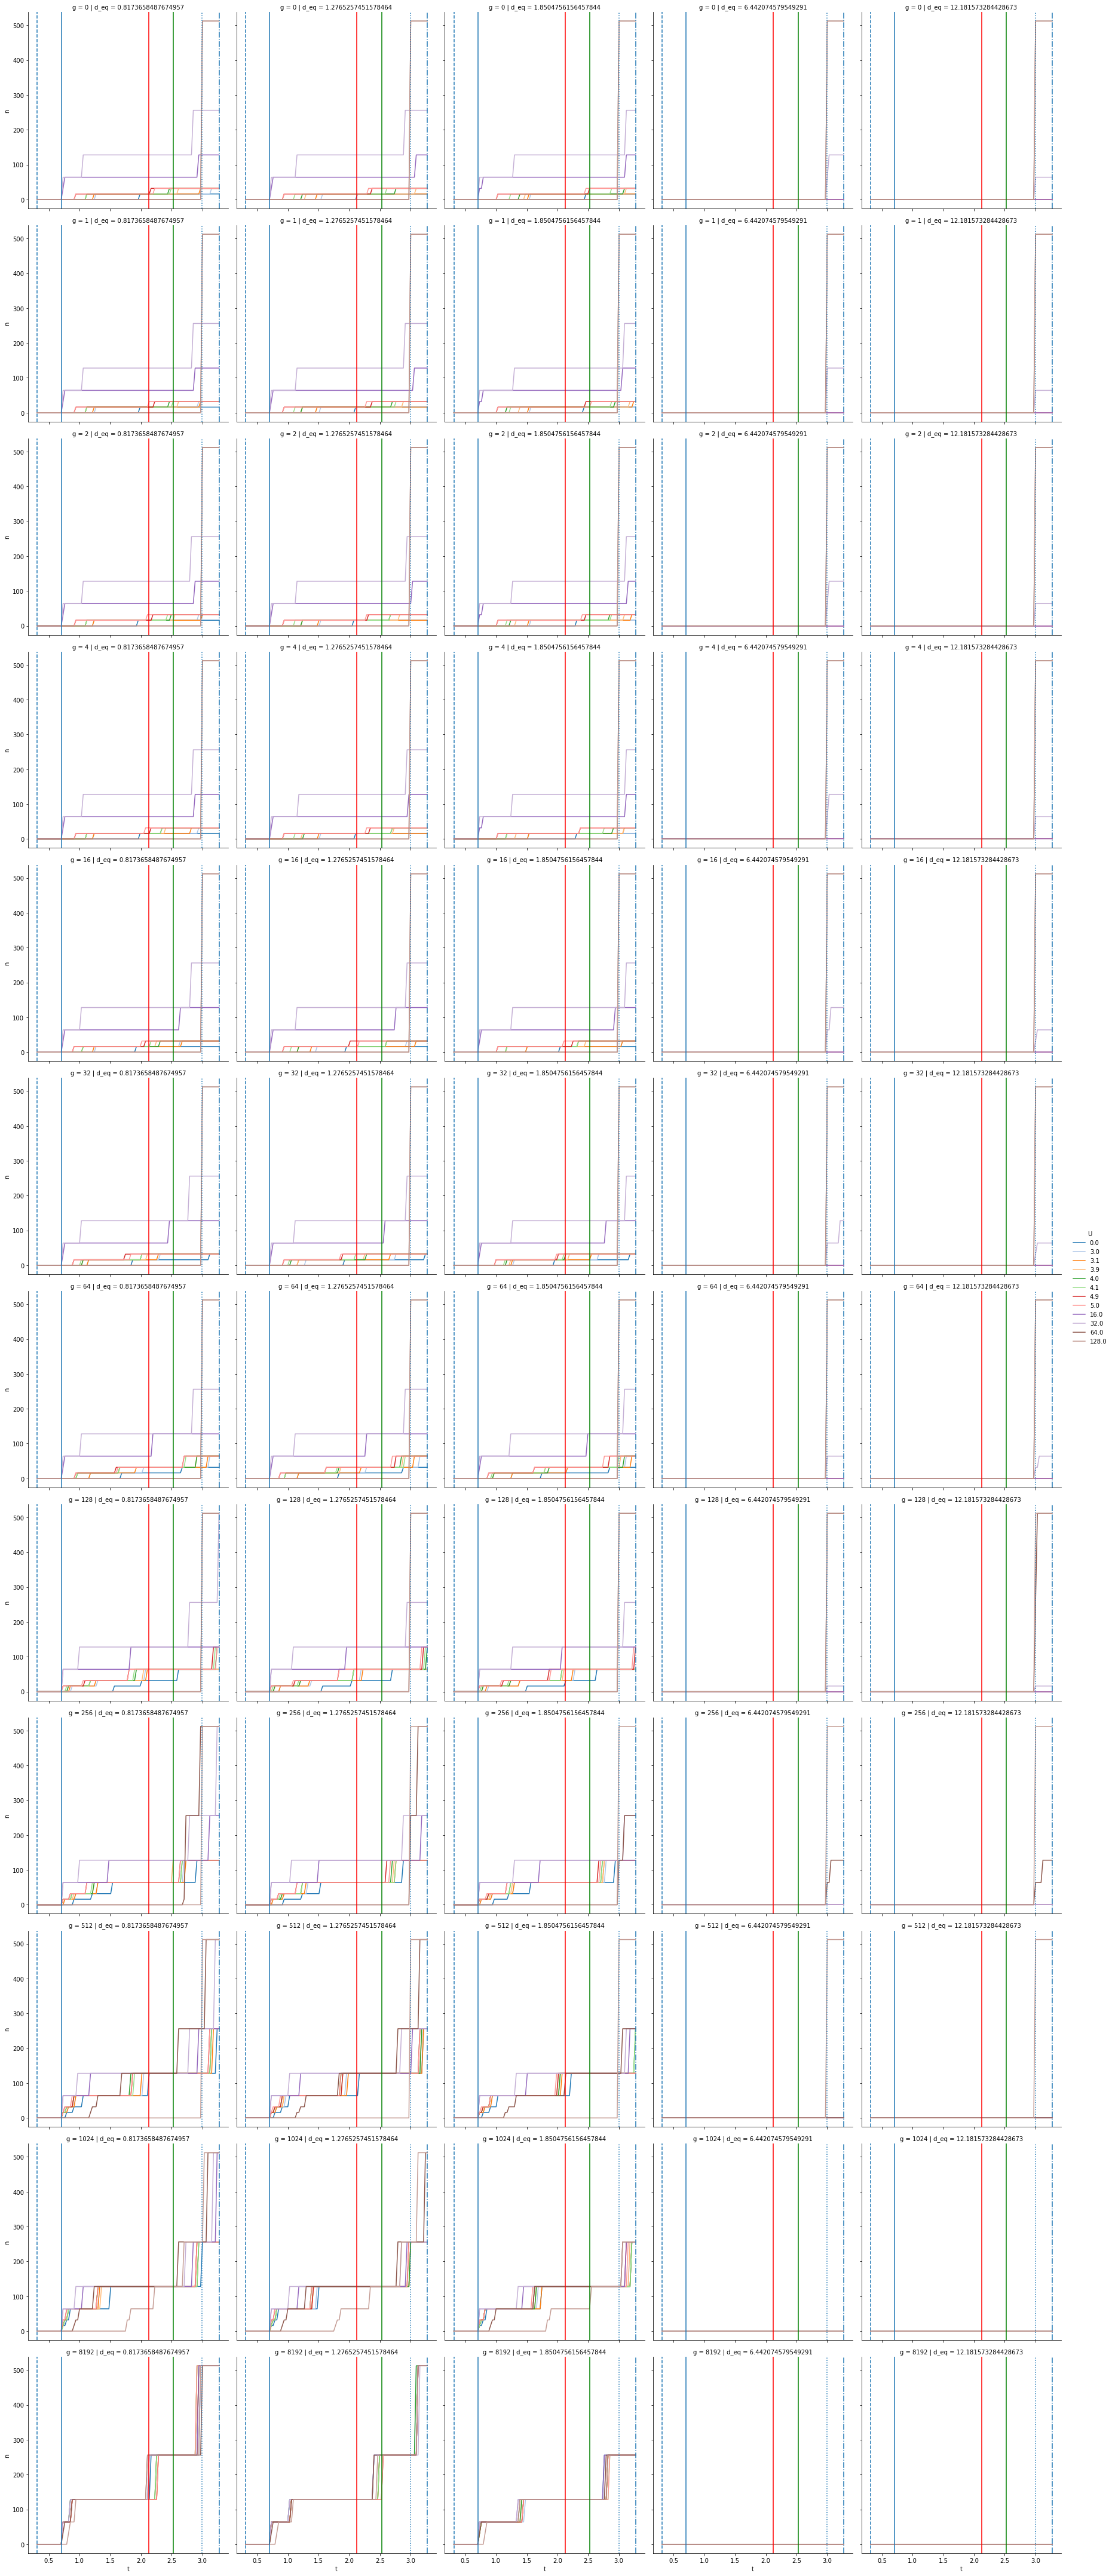

In [301]:
N=500
p=0.2

cap_filt = capacity[(capacity.N==N) & (capacity.p==p)]

g = sns.relplot(x="t", y="n", col="d_eq", row="g", hue="U", data=cap_filt, kind="line", palette="tab20") #, ci=None
# g.axes[0,0].set_yscale('log')
d_list = np.sort(cap_filt.d_eq.unique())

for i in range(g.axes.shape[0]):
    for j in range(g.axes.shape[1]):
        g.axes[i,j].axvline(x=min_j,linestyle='--')
        coeff_filt = coeff_df[(coeff_df.N==N) & (coeff_df.p==p)]
        g.axes[i,j].axvline(x=float(coeff_filt.intercept),linestyle='-')
        g.axes[i,j].axvline(x=max_j, linestyle='-.')
        g.axes[i,j].axvline(x=min_i, color='r')
        g.axes[i,j].axvline(x=max_i, color='g')
        g.axes[i,j].axvline(x=float(coeff_filt.slope)*N*p+float(coeff_filt.intercept), linestyle=':')

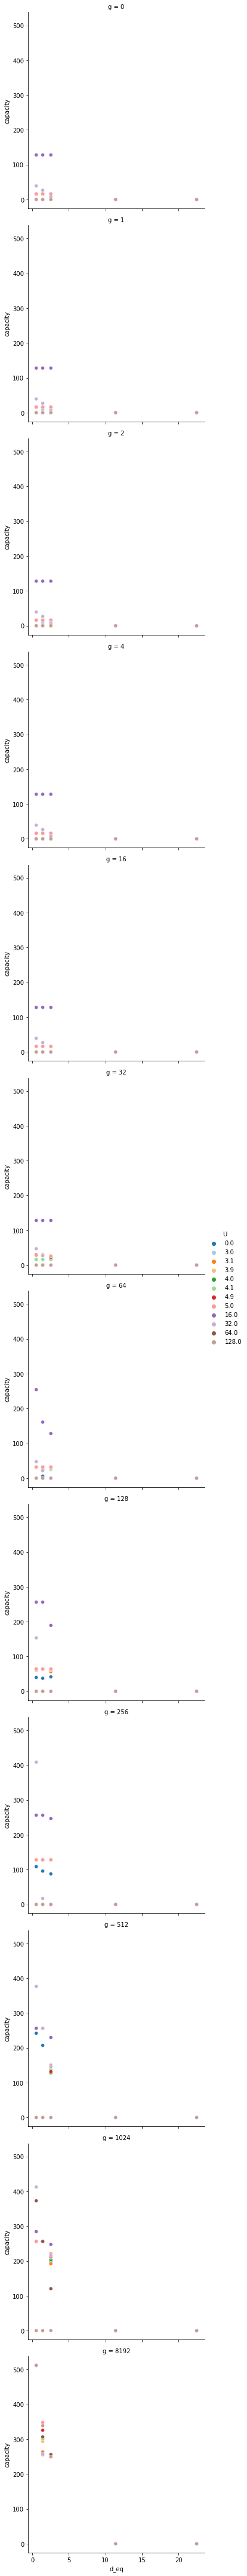

In [311]:
N=500
p=0.1

Np_filt = sum_max[(sum_max.N==N) & (sum_max.p==p)]

g = sns.relplot(x="d_eq", y="capacity", row="g", hue="U", data=Np_filt, kind="line", palette="tab20") #, ci=None

# g.axes[0,0].set_yscale('log')

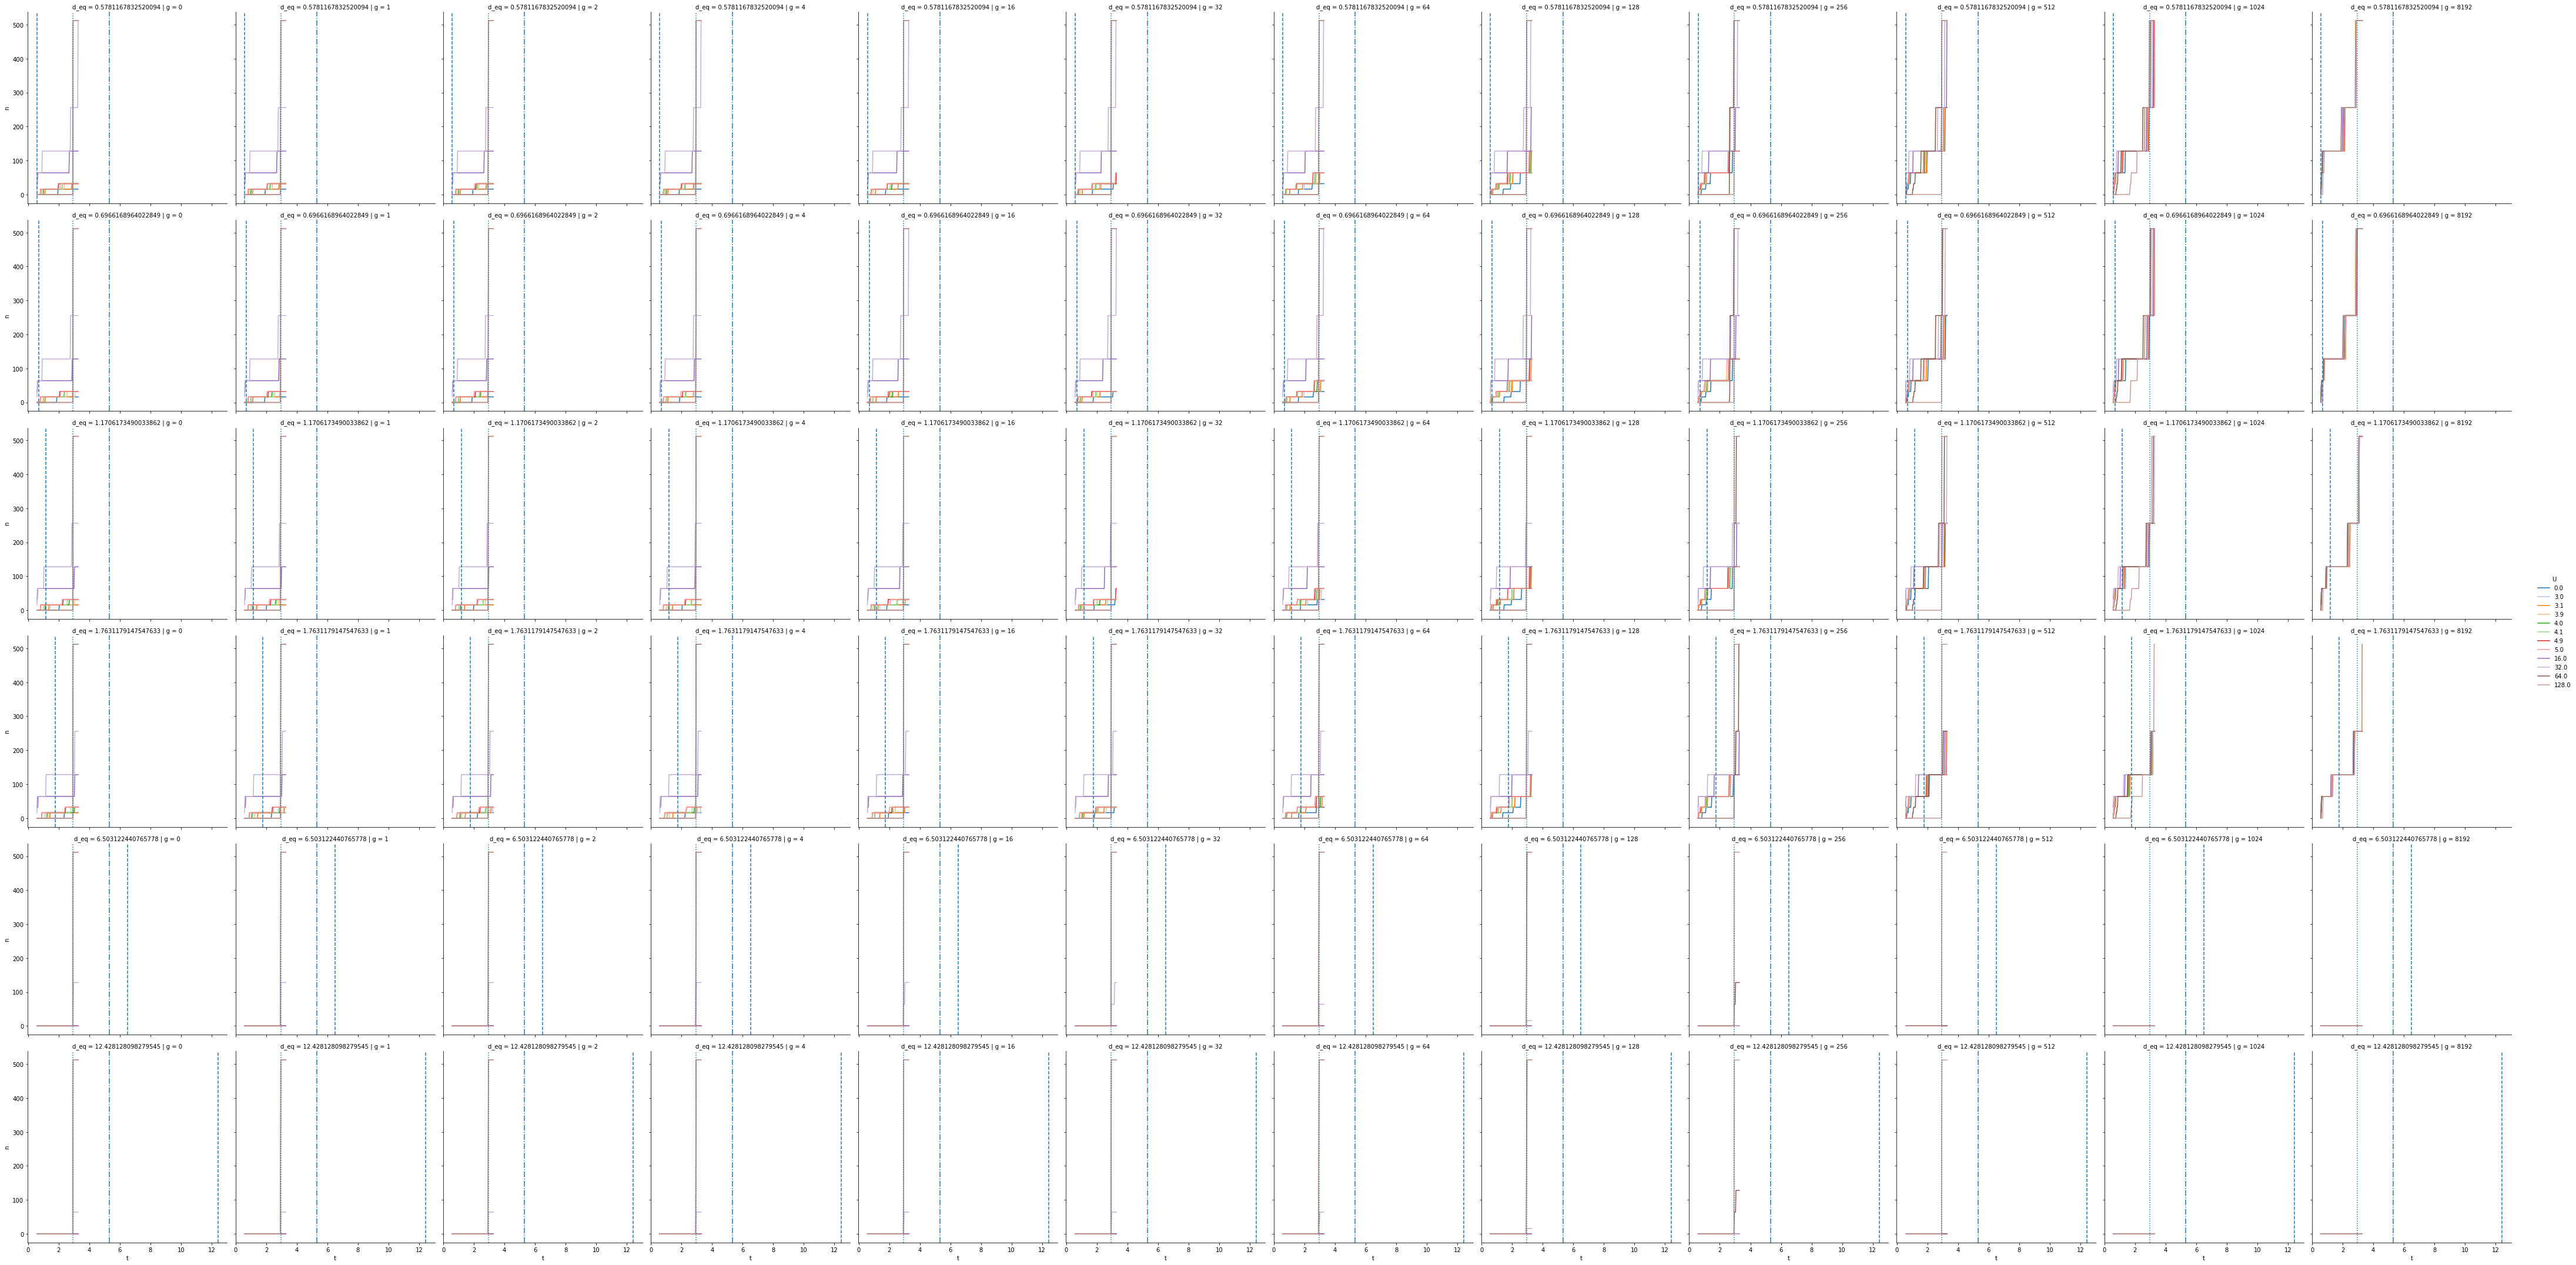

In [126]:
N=500
p=0.2

cap_filt = capacity[(capacity.N==N) & (capacity.p==p)]

g = sns.relplot(x="t", y="n", row="d_eq", col="g", hue="U", data=cap_filt, kind="line", palette="tab20") #, ci=None
# g.axes[0,0].set_yscale('log')
d_list = np.sort(cap_filt.d_eq.unique())

for i in range(len(d_list)):
    for j in range(len(g.axes[i])):
        g.axes[i,j].axvline(x=d_list[i],linestyle='--')
        coeff_filt = coeff_df[(coeff_df.N==N) & (coeff_df.p==p)]
        g.axes[i,j].axvline(x=float(coeff_filt.slope)*2*N*p+float(coeff_filt.intercept), linestyle='-.')
        g.axes[i,j].axvline(x=float(coeff_filt.slope)*N*p+float(coeff_filt.intercept), linestyle=':')

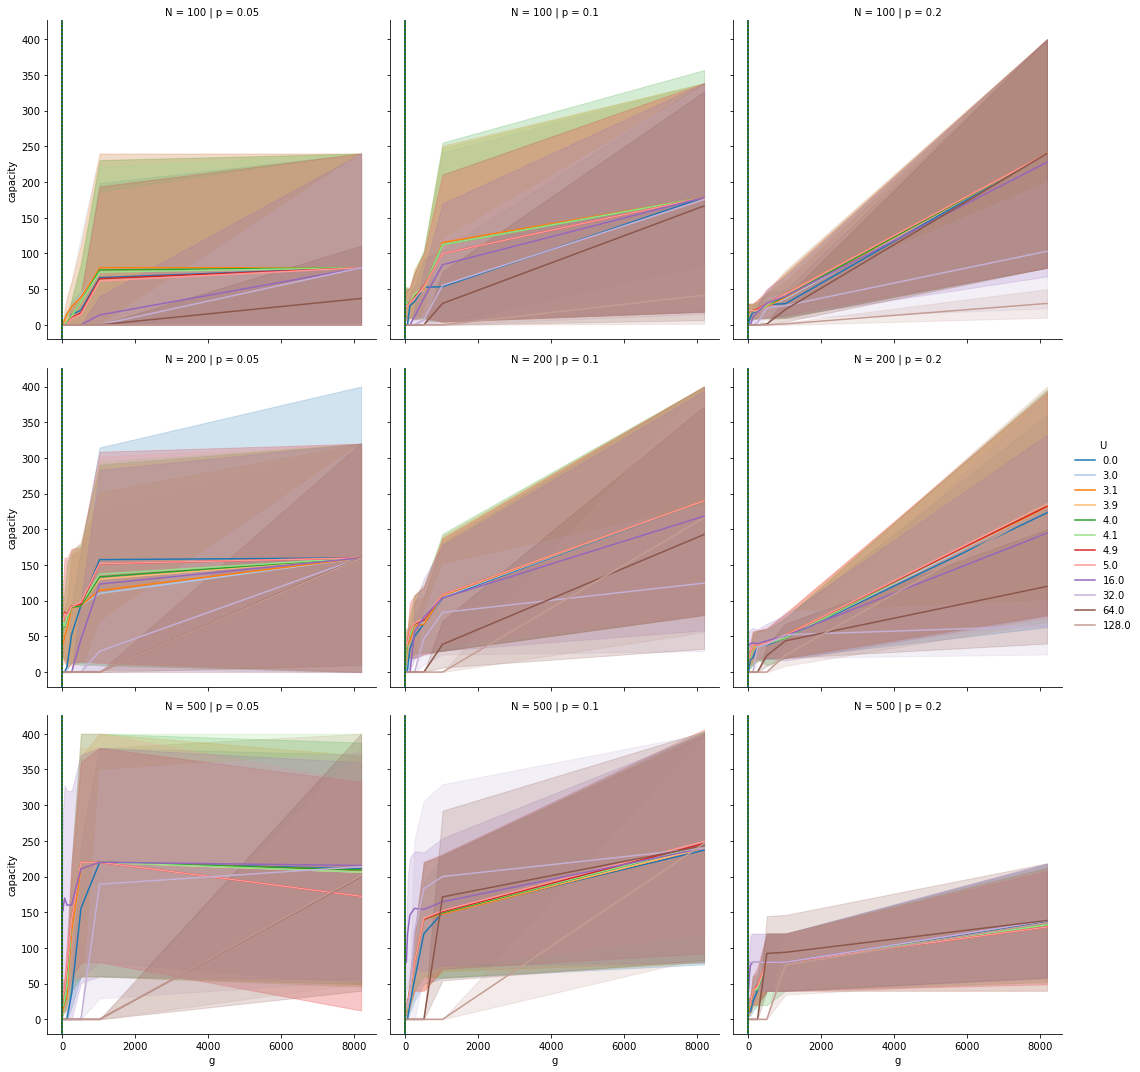

In [127]:
N=500
p=0.2

g = sns.relplot(x="g", y="capacity", col="p", row="N", hue="U", data=sum_max, kind="line", palette="tab20") #, ci=None
# g.axes[0,0].set_yscale('log')
d_list = np.sort(cap_filt.d_eq.unique())

for i in range(g.axes.shape[0]):
    for j in range(g.axes.shape[1]):
        g.axes[i,j].axvline(x=min_j,linestyle='--')
        coeff_filt = coeff_df[(coeff_df.N==N) & (coeff_df.p==p)]
        g.axes[i,j].axvline(x=float(coeff_filt.intercept),linestyle='-')
        g.axes[i,j].axvline(x=max_j, linestyle='-.')
        g.axes[i,j].axvline(x=min_i, color='r')
        g.axes[i,j].axvline(x=max_i, color='g')
        g.axes[i,j].axvline(x=float(coeff_filt.slope)*N*p+float(coeff_filt.intercept), linestyle=':')

## References

[1] Dasgupta, S., Stevens, C. F., & Navlakha, S. (2017). A neural algorithm for a fundamental computing problem. Science, 358(6364), 793-796. 

[2] Yagnik, J., Strelow, D., Ross, D. A., & Lin, R. S. (2011, November). The power of comparative reasoning. In 2011 International Conference on Computer Vision (pp. 2431-2438). IEEE.